# 라이브러리



In [2]:
!pip3 install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 52.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 데이터 불러오기

In [5]:
log_2023_path = "/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/데이터 분석 중급 프로젝트_1/원본 데이터/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/이전 분석/log_2023.csv"
log_2023_df = pd.read_csv(log_2023_path)

In [6]:
# 1. UTC 제거
log_2023_df["timestamp_clean"] = log_2023_df["timestamp"].str.replace(" UTC", "", regex=False)

# 2. datetime으로 변환
log_2023_df["timestamp_clean"] = pd.to_datetime(
    log_2023_df["timestamp_clean"],
    format="%Y-%m-%d %H:%M:%S.%f",
    errors="coerce"
)

# 3. NaT가 생긴 경우, 포맷이 다른 문자열을 다시 처리 (마이크로초 없는 경우 등)
mask_failed = log_2023_df["timestamp_clean"].isna()
log_2023_df.loc[mask_failed, "timestamp_clean"] = pd.to_datetime(
    log_2023_df.loc[mask_failed, "timestamp"].str.replace(" UTC", "", regex=False),
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

# 4. 정리
log_2023_df["timestamp"] = log_2023_df["timestamp_clean"]
log_2023_df.drop(columns="timestamp_clean", inplace=True)

In [7]:
# 쿼리 파라미터 제거
log_2023_df["cleaned_url"] = log_2023_df["URL"].str.split("?").str[0]

# Acquisition

## acquisition_urls = 회원가입을 시도한 모든 URL

In [ ]:
cleaned_unique_urls = log_2023_df["cleaned_url"].unique()

acquisition_keywords = [
    "signup",
    "signup/step1",
    "signup/step2",
    "signup/step3",
    "api/signup",
    "email_verify",
    "verify_phone"
]

# Acquisition URL로 분류
acquisition_urls = [url for url in cleaned_unique_urls if isinstance(url, str) and any(kw in url for kw in acquisition_keywords)]

## acquisition_logs = 회원가입을 시도한 모든 URL로 필터링한 데이터프레임

In [ ]:
# 가입 관련 URL 방문 로그 추출
acquisition_logs = log_2023_df[log_2023_df["cleaned_url"].isin(acquisition_urls)]

In [ ]:
acquisition_logs

## signup_done = 회원가입 완료(signup/step3/done 경로에 도달)한 유저 모음 데이터프레임

In [ ]:
signup_done = acquisition_logs[acquisition_logs["cleaned_url"] == "signup/step3/done"]

In [ ]:
len(log_2023_df["user_uuid"].unique())

- 해당 데이터프레임에 있는 모든 고유 사용자 수: 15,366명

In [ ]:
len(acquisition_logs["user_uuid"].unique())

- 회원가입을 시도한 모든 고유 사용자 수: 4,105명

In [ ]:
len(signup_done["user_uuid"].unique())

- 회원가입을 완료한 사람: 2,030명

- 회원가입 완료 사용자 / 전체 고유 사용자 = 2030 / 15366 = 26.22%
- 회원가입 완료 사용자 / 회원가입 시도 사용자 = 2030 / 4105 = 49.45%

# Activation

## 회원가입을 완료한 신규 유저 (acquisition_members_df)

In [ ]:
# 신규 회원가입 완료한 유저 리스트
acquisition_members = signup_done["user_uuid"].astype(str).unique().tolist()

In [ ]:
# 안전하게 set으로 저장
acquisition_members_set = set(acquisition_members)

In [ ]:
# log_2023_df에서 acquisition_members_set의 값을 가지는 행 필터링
log_2023_df["user_uuid"] = log_2023_df["user_uuid"].astype(str)
acquisition_members_df = log_2023_df[log_2023_df["user_uuid"].isin(acquisition_members_set)]

In [ ]:
acquisition_members_df

In [ ]:
len(acquisition_members_df["user_uuid"].unique())

## 회원가입 완료한 신규 유저 중 "jobs/id/apply/step4" 경로에 도달한 유저 (activation_members)

In [ ]:
activation_members = acquisition_members_df[acquisition_members_df["cleaned_url"] == "jobs/id/apply/step4"]

In [ ]:
activation_members

In [ ]:
len(activation_members["user_uuid"].unique())

## 회원가입 완료한 신규 유저 중 "jobs/id/apply/complete" 경로에 도달한 유저 (activation_complete_members)

In [ ]:
activation_complete_members = acquisition_members_df[acquisition_members_df["cleaned_url"] == "jobs/id/apply/complete"]

In [ ]:
activation_complete_members

In [ ]:
# timestamp 기준으로 정렬
activation_complete_members = activation_complete_members.sort_values(by="timestamp")
activation_complete_members = activation_complete_members.reset_index(drop=True)

# 결과 확인
activation_complete_members

- 기존 회원가입 완료 = 	jobs/id/apply/step4

- 2023-05-24 이후로 complete라는 페이지 생겼을 것으로 추측
    - 5월 23일까지는 회원가입 4단계에서 확인 누르면 바로 메인화면 혹은 로그인 화면으로 이동
    - 5월 24일 부터는 4단계에서 확인 누르면 '회원가입이 완료되었어요~ 축하해요~'하는 페이지 있을 것으로 추측

In [ ]:
len(activation_complete_members["user_uuid"].unique())

## 회원가입 완료한 신규 유저 중 "api/jobs/id/apply/step4" 경로에 도달한 유저 (activation_members) api 활용

In [ ]:
activation_members = acquisition_members_df[acquisition_members_df["cleaned_url"] == "api/jobs/id/apply/step4"]

In [ ]:
activation_members

In [ ]:
len(activation_members["user_uuid"].unique())

- Activation 인원 1,913명

## application.csv 확인

In [ ]:
application_path = "/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/데이터 분석 중급 프로젝트_1/원본 데이터/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/이전/Application.csv"
application_df = pd.read_csv(application_path)

In [ ]:
application_df

In [ ]:
# cdate를 datetime 타입으로 변환
application_df["cdate"] = pd.to_datetime(application_df["cdate"], format="mixed")

# 2023년도에 해당하는 데이터 필터링
application_2023_df = application_df[application_df["cdate"].dt.year == 2023]

In [ ]:
# application_df acquisition_members_set의 값을 가지는 행 필터링
application_2023_df["user_uuid"] = application_2023_df["user_uuid"].astype(str)
application_acquisition_members_df = application_2023_df[application_2023_df["user_uuid"].isin(acquisition_members_set)]

In [ ]:
application_acquisition_members_df

In [ ]:
len(application_acquisition_members_df["user_uuid"].unique())

- application_df에서 확인한 회원가입을 완료한 신규 유저의 수 = 1,937명
    - activation_members를 통해 확인한 Activation 인원 대비 +24명

## 문제가 되는 24명 찾기

In [ ]:
activation_members["user_uuid"].unique()

In [ ]:
application_acquisition_members_df["user_uuid"].unique()

In [ ]:
# 두 unique 값의 리스트를 set으로 변환
activation_uuids = set(activation_members["user_uuid"].unique())
acquisition_uuids = set(application_acquisition_members_df["user_uuid"].unique())

# activation_members에는 있는데 application_acquisition_members_df 없는 값 찾기
missing_in_acquisition = acquisition_uuids - activation_uuids

# 결과 출력
missing_in_acquisition

In [ ]:
# 두 개의 누락된 UUID를 제거한 새로운 activation UUID set 생성
activation_uuids_minus_missing = acquisition_uuids - missing_in_acquisition

# acquisition_uuids와 동일한지 확인
activation_uuids_minus_missing == activation_uuids

### 24명의 문제아들

In [ ]:
problem = ['0ca6b4fa-ad3f-4401-a9c5-3f5d2df8934f',
 '0e607861-f580-408d-8207-756133b88702',
 '113a7459-e1ea-444a-9f53-0832cbec694d',
 '31e47379-6e3e-4ba7-adf7-a49ed1e3a88a',
 '4ccf9a9e-a39d-4dcf-9119-f8c996b511c7',
 '5ca1c882-698d-47b5-8639-78ea13a98a50',
 '5df3d514-36d3-4df9-97ac-e9368e7ee395',
 '704a3721-2d0f-442a-bd88-bab5e33ec949',
 '7edb5c66-57b5-4cf9-b2b2-09de524cdde8',
 '830f41a0-4a23-4bee-aada-363d91238d16',
 '8d7aada7-e6c7-4cf2-b1fb-9e16e67464ec',
 '90c225b4-d269-49af-9fcd-36d95afd3f7e',
 '9d0ac5fc-75b3-420d-953a-49718c032340',
 'b3c1b62d-7c12-47ac-9f6c-a89925a31024',
 'b665e91d-769f-4f91-b6b6-749f871ee34a',
 'beae7f9f-5ee7-40b5-96a6-26213acdf408',
 'c5bd06b8-73dd-4b10-a409-dd8840051b01',
 'd94c50f7-b887-4ffb-92cc-7551e76a8fd0',
 'da0de1ef-2949-45ec-8634-90c27a760099',
 'df1ad335-6164-458b-82b9-48d0b6bb577d',
 'dfd725c8-d423-433c-b499-69f531f7e419',
 'ee7d8349-2d00-4341-a8fa-748c44895760',
 'f086754e-8e50-418b-915e-79ac30465893',
 'f71c54be-8ea6-4836-adf3-5366a1e462f7']

In [ ]:
# 리스트에 있는 UUID가 signup_done 데이터프레임의 user_uuid 컬럼에 포함되어 있는지 확인
signup_done["in_problem_list"] = signup_done["user_uuid"].isin(problem)

# 포함된 값만 보고 싶다면 아래와 같이 필터링할 수 있어
matched_users = signup_done[signup_done["in_problem_list"]]

len(matched_users["user_uuid"].unique())

- 획득단계에서 확인한 결과 problem 리스트에 포함된 유저(문제아)가 모두 2023년에 신규 회원가입을 완료한 사람들임을 확인

### 신규 회원가입한 시간 확인

- matched_users = 문제아들이 신규 회원가입 관련 활동을 한 데이터프레임

In [ ]:
matched_users.info()

In [ ]:
matched_users['cdate'] = pd.to_datetime(matched_users['date'])

In [ ]:
matched_users['cdate'].unique()

In [ ]:
# timestamp 기준으로 정렬
matched_users = matched_users.sort_values(by="cdate")
matched_users = matched_users.reset_index(drop=True)

# 결과 확인
matched_users

### bookmark_df에 있는지?

In [ ]:
bookmark_path = "/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/데이터 분석 중급 프로젝트_1/원본 데이터/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/이전/JobBookmark.csv"
bookmark_df = pd.read_csv(bookmark_path)

In [ ]:
# 리스트에 있는 UUID가 signup_done 데이터프레임의 user_uuid 컬럼에 포함되어 있는지 확인
bookmark_df["in_problem_list"] = bookmark_df["user_uuid"].isin(problem)

# 포함된 값만 보고 싶다면 아래와 같이 필터링할 수 있어
bookmark_matched_users = bookmark_df[bookmark_df["in_problem_list"]]

bookmark_matched_users

In [ ]:
# timestamp 기준으로 정렬
bookmark_matched_users = matched_users.sort_values(by="cdate")
bookmark_matched_users = matched_users.reset_index(drop=True)

# 결과 확인
bookmark_matched_users

## 문제아1의 로그 데이터

In [ ]:
problem_member_12 = activation_members[activation_members["user_uuid"] == "31e47379-6e3e-4ba7-adf7-a49ed1e3a88a"]
problem_member_12

In [ ]:
problem_member_1 = log_2023_df[log_2023_df["user_uuid"] == "0ca6b4fa-ad3f-4401-a9c5-3f5d2df8934f"]
problem_member_1

In [ ]:
# timestamp 기준으로 정렬
problem_member_1 = problem_member_1.sort_values(by="timestamp")
problem_member_1 = problem_member_1.reset_index(drop=True)

# 결과 확인
problem_member_1

In [ ]:
p1_step_4 = problem_member_1[problem_member_1["cleaned_url"] == "api/jobs/id/apply/step4"]
p1_step_4

## 문제아2의 로그 데이터

In [ ]:
application_df[application_df["user_uuid"] == "0e607861-f580-408d-8207-756133b88702"]

In [ ]:
problem_member_2 = log_2023_df[log_2023_df["user_uuid"] == "0e607861-f580-408d-8207-756133b88702"]
problem_member_2

In [ ]:
# timestamp 기준으로 정렬
problem_member_2 = problem_member_2.sort_values(by="timestamp")
problem_member_2 = problem_member_2.reset_index(drop=True)

# 결과 확인
problem_member_2

In [ ]:
p1_step_4 = problem_member_2[problem_member_2["cleaned_url"] == "jobs/id/apply/step4"]
p1_step_4

In [ ]:
problem_member_2["cleaned_url"].unique()

In [ ]:
problem2 = application_df[application_df["user_uuid"] == "0e607861-f580-408d-8207-756133b88702"]
problem2

In [ ]:
dec_3 = activation_members[activation_members["date"] == "2023-12-03"]
pr_2 = dec_3[dec_3["user_uuid"] == "0e607861-f580-408d-8207-756133b88702"]
pr_2

## 문제아 3

In [ ]:
application_df[application_df["user_uuid"] == "113a7459-e1ea-444a-9f53-0832cbec694d"]

In [ ]:
problem_member_3 = log_2023_df[log_2023_df["user_uuid"] == "113a7459-e1ea-444a-9f53-0832cbec694d"]
problem_member_3

In [ ]:
# timestamp 기준으로 정렬
problem_member_3 = problem_member_3.sort_values(by="timestamp")
problem_member_3 = problem_member_3.reset_index(drop=True)

# 결과 확인
problem_member_3

In [ ]:
p3_step_4 = problem_member_3[problem_member_3["cleaned_url"] == "jobs/id/apply/step3"]
p3_step_4

In [ ]:
problem_member_3["cleaned_url"].unique()

In [ ]:
problem3 = application_df[application_df["user_uuid"] == "113a7459-e1ea-444a-9f53-0832cbec694d"]
problem3

In [ ]:
dec_10 = activation_members[activation_members["date"] == "2023-12-10"]
pr_2 = dec_10[dec_10["user_uuid"] == "113a7459-e1ea-444a-9f53-0832cbec694d"]
pr_2

## 문제아 24명 어떻게 처리할 것인가?

- application.csv 테이블에서 확인
- bookmark.csv 테이블에서 확인
- log_2023.csv 테이블에서 확인
    - 이 세 테이블에서 모두 크로스체크 해봄
    - 적절한 문제점 확인하지 못함
        - 문제아 24명 모두 log, bookmark 테이블에서는 2023년도에 다른 활동은 모두 있었지만
        - application 테이블에서 지원 완료한 날에 로그 데이터에서 활성화 활동(step4)을 확인하지 못함

- 결론: 24명 배제

# Retention

- 지원 완료 -> 다음 행동?
    - 이력서 작성을 다시 해볼 수 있고
    - 공고 검색을 해볼 수 있고
    - 기업도 검색해 볼 수 있고
    - 추가 지원도 해볼 수 있고

## '로그 공부.ipynb'

- 개인 프로필 수정, 작성 -> 지원하기 위해
    - api/users/id/education
        - 특정 사용자의 학력 데이터를 다루는 API 요청 (불러오기, 추가, 수정 등)

    - api/users/id/career
        - 특정 사용자의 경력 데이터를 다루는 API 요청 (불러오기, 추가, 수정 등)

    - api/users/id/project
        - 특정 사용자의 프로젝트 경험 데이터를 다루는 API 요청 (불러오기, 추가, 수정 등)

    - api/users/id/image
        - 특정 사용자의 이미지 업로드나 수정 요청을 처리하는 API 경로

    - api/users/id/resume/step1
        - 특정 사용자의 이력서 작성 흐름 중 첫 단계의 데이터 처리 API 요청

- 기업 검색 -> 지원할 기업 탐색
    - api/search/companies
        - 기업을 키워드나 필터로 검색할 때 사용하는 API

 - 지원 -> 꼭 지원을 마무리한다 (X) 지원 시도 혹은 공고를 열람한다 (O)
    - jobs/id/apply/step1 ~ jobs/id/apply/step4
        - jobs/id: 특정 채용 공고

        - 사용자가 지원하는 과정에서 1단계부터 4단계까지의 각 지원 페이지 (예: 이력서 선택 → 자기소개서 입력 → 확인 → 완료)

    - jobs/id -> 채용 공고 열람이라고 해석 가능 -> apply 경로가 추가되면 지원하기 버튼 눌렀다고 해석

- 기업 프로필 확인 -> 지원할 기업에 대해 탐색
    - companies/company_id/jobs
        - 특정 기업의 전체 채용공고를 보여주는 페이지

    - api/companies/id/view
        - 특정 기업의 상세 정보를 백엔드에서 요청하는 API

- 외부 sns 연동 -> 지원하기 위한 프로필 작성
    - api/users/id/sns
        - 특정 사용자의 SNS 연동 상태를 처리하는 API (연결, 해제 등)

    - api/users/id/profile_image/facebook
        - 페이스북 계정에서 프로필 사진을 가져오는 API 요청

    - api/verify/education/id
        - 사용자가 입력한 학력 정보를 검증하는 API 요청

## Retention 단계 정의

In [ ]:
retention_keywords = [
    "api/users/id/education",
    "api/users/id/career",
    "api/users/id/project",
    "api/users/id/image",
    "api/users/id/resume",
    "api/search/companies",
    "companies/company_id/jobs",
    "api/companies/id/view",
    "jobs/id",
    "jobs/id/apply",
    "api/users/id/sns",
    "api/users/id/profile_image/facebook",
    "api/verify/education/id"
]

# Retention URL로 분류
retention_urls = [url for url in cleaned_unique_urls if isinstance(url, str) and any(kw in url for kw in retention_keywords)]

In [ ]:
retention_urls

## 최초 지원 완료 지점 설정

- activation_members_df = 2023년에 활성화 된 유저 데이터프레임

In [ ]:
activated_members = activation_members["user_uuid"].astype(str).unique().tolist()

In [ ]:
activated_members_set = set(activated_members)

In [ ]:
# log_2023_df에서 activated_members_set 값을 가지는 행 필터링
log_2023_df["user_uuid"] = log_2023_df["user_uuid"].astype(str)
activation_members_df = log_2023_df[log_2023_df["user_uuid"].isin(activated_members_set)]

In [ ]:
activation_members_df

In [ ]:
activation_members.groupby("user_uuid")

In [ ]:
# timestamp 기준으로 정렬
activation_members_df = activation_members_df.sort_values(by="timestamp")
activation_members_df = activation_members_df.reset_index(drop=True)

# 결과 확인
activation_members_df

In [ ]:
test_activation_members_df = activation_members_df.copy()

- after_apply = 최초 지원 완료 시점 이후 로그데이터만 모아놓은 데이터프레임

In [ ]:
# "apply/step4"이 처음 등장한 인덱스를 기록할 딕셔너리 생성
first_apply_index = {}

# 그룹화 후 각 유저별로 처리
for user, group in test_activation_members_df.groupby("user_uuid"):
    # "api/jobs/id/apply/step4"이 있는 행 필터링
    apply_rows = group[group["cleaned_url"] == "api/jobs/id/apply/step4"]

    # 만약 해당 URL이 존재하면, 그 중 첫 번째 인덱스를 저장
    if not apply_rows.empty:
        first_index = apply_rows.index[0]
        first_apply_index[user] = first_index

# 삭제 기준 인덱스 목록 만들기
rows_to_keep = []
for user, group in test_activation_members_df.groupby("user_uuid"):
    if user in first_apply_index:
        # 해당 유저에서 apply/step4가 처음 등장한 인덱스 이후부터 유지
        idx_to_keep = group.loc[first_apply_index[user]:].index
        rows_to_keep.extend(idx_to_keep)

# 최종 결과: 필요한 행만 유지
after_apply_df = test_activation_members_df.loc[rows_to_keep].reset_index(drop=True)

after_apply_df

## Retention

In [ ]:
# 가입 관련 URL 방문 로그 추출
retention_logs = after_apply_df[after_apply_df["cleaned_url"].isin(retention_urls)]

In [ ]:
retention_logs

In [ ]:
len(retention_logs["user_uuid"].unique())

- 1,993명이 모두 유지되었다 (X) 119명이 지원을 완료하고 바로 창을 나갔다 (O)

In [ ]:
# cleaned_url별로 등장 횟수 세기
url_counts = retention_logs["cleaned_url"].value_counts()

# 결과 출력
url_counts

## 범위 리텐션

- 각 유저별 최초 지원 완료일 기준 7일(30일)간 활동 내역이 있으면 유지

In [ ]:
test_after_apply_df = after_apply_df.copy()

In [ ]:
# 지원한 시점 기준으로 유저별 최초 지원일 구하기
apply_logs = test_after_apply_df[test_after_apply_df["cleaned_url"] == "api/jobs/id/apply/step4"]
first_apply = apply_logs.groupby("user_uuid")["timestamp"].min().reset_index()
first_apply.columns = ["user_uuid", "first_apply_time"]

# 원본 데이터에 최초 지원일 병합
df = test_after_apply_df.merge(first_apply, on="user_uuid", how="left")

# 최초 지원일로부터 경과일 수 계산
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["first_apply_time"] = pd.to_datetime(df["first_apply_time"])
df["days_since_apply"] = (df["timestamp"] - df["first_apply_time"]).dt.days

# 7일 단위 주차로 그룹핑 (0주차 = Day 0~6, 1주차 = Day 7~13, ...)
df["week_number"] = (df["days_since_apply"] // 7)

# 유저별 활동한 주차 정보 추출
retention = df.groupby(["user_uuid", "week_number"]).size().reset_index(name="activity_count")

# Pivot: retention table 생성
retention_pivot = retention.pivot_table(index="user_uuid", columns="week_number", values="activity_count", fill_value=0)

# Binary 형태로 변환 (해당 주차에 활동했으면 1)
retention_binary = retention_pivot.applymap(lambda x: 1 if x > 0 else 0)

# 전체 유저 수로 나눠서 각 주차별 유지율 계산
retention_rate = retention_binary.sum(axis=0) / retention_binary.shape[0]

# 보기 좋게 정리
retention_rate_df = retention_rate.reset_index()
retention_rate_df.columns = ["week", "retention_rate"]
retention_rate_df["week"] = retention_rate_df["week"].astype(int)
retention_rate_df = retention_rate_df.sort_values("week").reset_index(drop=True)

retention_rate_df

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(retention_rate_df["week"], retention_rate_df["retention_rate"], marker="o", color="royalblue")

plt.title("Weekly Retention Rate (범위 리텐션)", fontsize=16)
plt.xlabel("Week Number (주차)", fontsize=12)
plt.ylabel("Retention Rate", fontsize=12)
plt.xticks(retention_rate_df["week"])  # 모든 주차 보이게
plt.grid(True, linestyle="--", alpha=0.5)

# y축 퍼센트 포맷
plt.gca().set_yticklabels([f"{y:.0%}" for y in plt.gca().get_yticks()])

plt.tight_layout()
plt.show()

In [ ]:
# 지원한 시점 기준으로 유저별 최초 지원일 구하기
apply_logs = test_after_apply_df[test_after_apply_df["cleaned_url"] == "api/jobs/id/apply/step4"]
first_apply = apply_logs.groupby("user_uuid")["timestamp"].min().reset_index()
first_apply.columns = ["user_uuid", "first_apply_time"]

# 원본 데이터에 최초 지원일 병합
df = test_after_apply_df.merge(first_apply, on="user_uuid", how="left")

# 최초 지원일로부터 경과일 수 계산
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["first_apply_time"] = pd.to_datetime(df["first_apply_time"])
df["days_since_apply"] = (df["timestamp"] - df["first_apply_time"]).dt.days

# 7일 단위 주차로 그룹핑 (0주차 = Day 0~6, 1주차 = Day 7~13, ...)
df["month_number"] = (df["days_since_apply"] // 30)

# 유저별 활동한 주차 정보 추출
retention = df.groupby(["user_uuid", "month_number"]).size().reset_index(name="activity_count")

# Pivot: retention table 생성
retention_pivot = retention.pivot_table(index="user_uuid", columns="month_number", values="activity_count", fill_value=0)

# Binary 형태로 변환 (해당 주차에 활동했으면 1)
retention_binary = retention_pivot.applymap(lambda x: 1 if x > 0 else 0)

# 전체 유저 수로 나눠서 각 주차별 유지율 계산
retention_rate = retention_binary.sum(axis=0) / retention_binary.shape[0]

# 보기 좋게 정리
retention_rate_30d_df = retention_rate.reset_index()
retention_rate_30d_df.columns = ["month", "retention_rate"]
retention_rate_30d_df["month"] = retention_rate_30d_df["month"].astype(int)
retention_rate_30d_df = retention_rate_30d_df.sort_values("month").reset_index(drop=True)

retention_rate_30d_df

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(retention_rate_30d_df["month"], retention_rate_30d_df["retention_rate"], marker="o", color="royalblue")

plt.title("monthly Retention Rate (범위 리텐션)", fontsize=16)
plt.xlabel("month Number (월)", fontsize=12)
plt.ylabel("Retention Rate", fontsize=12)
plt.xticks(retention_rate_30d_df["month"])  # 모든 주차 보이게
plt.grid(True, linestyle="--", alpha=0.5)

# y축 퍼센트 포맷
plt.gca().set_yticklabels([f"{y:.0%}" for y in plt.gca().get_yticks()])

plt.tight_layout()
plt.show()

## 클래식 리텐션

- 각 유저별 최초 지원 완료일 기준 7일(30일)이 되는 날 활동 내역이 있으면 유지

In [ ]:
# 지원한 시점 기준으로 유저별 최초 지원일 구하기
apply_logs = test_after_apply_df[test_after_apply_df["cleaned_url"] == "api/jobs/id/apply/step4"]
first_apply = apply_logs.groupby("user_uuid")["timestamp"].min().reset_index()
first_apply.columns = ["user_uuid", "first_apply_time"]

# 원본 데이터에 최초 지원일 병합
df = test_after_apply_df.merge(first_apply, on="user_uuid", how="left")

# 최초 지원일로부터 경과일 수 계산
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["first_apply_time"] = pd.to_datetime(df["first_apply_time"])
df["days_since_apply"] = (df["timestamp"] - df["first_apply_time"]).dt.days

# 7일, 14일, 21일, 28일 ...
retention_df = df[df["days_since_apply"] % 7 == 0]

# 각 row에 해당하는 'week' 정보 추가
retention_df["week"] = retention_df["days_since_apply"] // 7

# 최초 지원자 수 (week 0 기준 active 사용자 수)
week0_users = retention_df[retention_df["week"] == 0]["user_uuid"].nunique()

# week별 리텐션 계산: 각 주차에 한 번이라도 접속한 유저 수 / 최초 유저 수
weekly_retention = (
    retention_df.groupby("week")["user_uuid"]
    .nunique()
    .reset_index()
    .rename(columns={"user_uuid": "retained_users"})
)
weekly_retention["retention_rate"] = weekly_retention["retained_users"] / week0_users

weekly_retention

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_retention["week"], weekly_retention["retention_rate"], marker="o", color="royalblue")

plt.title("weekly Retention Rate (클래식 리텐션)", fontsize=16)
plt.xlabel("week Number (주차)", fontsize=12)
plt.ylabel("Retention Rate", fontsize=12)
plt.xticks(weekly_retention["week"])  # 모든 주차 보이게
plt.grid(True, linestyle="--", alpha=0.5)

# y축 퍼센트 포맷
plt.gca().set_yticklabels([f"{y:.0%}" for y in plt.gca().get_yticks()])

plt.tight_layout()
plt.show()

In [ ]:
# 지원한 시점 기준으로 유저별 최초 지원일 구하기
apply_logs = test_after_apply_df[test_after_apply_df["cleaned_url"] == "api/jobs/id/apply/step4"]
first_apply = apply_logs.groupby("user_uuid")["timestamp"].min().reset_index()
first_apply.columns = ["user_uuid", "first_apply_time"]

# 원본 데이터에 최초 지원일 병합
df = test_after_apply_df.merge(first_apply, on="user_uuid", how="left")

# 최초 지원일로부터 경과일 수 계산
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["first_apply_time"] = pd.to_datetime(df["first_apply_time"])
df["days_since_apply"] = (df["timestamp"] - df["first_apply_time"]).dt.days

# 7일, 14일, 21일, 28일 ...
retention_df = df[df["days_since_apply"] % 30 == 0]

# 각 row에 해당하는 'week' 정보 추가
retention_df["month"] = retention_df["days_since_apply"] // 30

# 최초 지원자 수 (week 0 기준 active 사용자 수)
week0_users = retention_df[retention_df["month"] == 0]["user_uuid"].nunique()

# week별 리텐션 계산: 각 주차에 한 번이라도 접속한 유저 수 / 최초 유저 수
weekly_retention = (
    retention_df.groupby("month")["user_uuid"]
    .nunique()
    .reset_index()
    .rename(columns={"user_uuid": "retained_users"})
)
weekly_retention["retention_rate"] = weekly_retention["retained_users"] / week0_users

weekly_retention

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_retention["month"], weekly_retention["retention_rate"], marker="o", color="royalblue")

plt.title("monthly Retention Rate (클래식 리텐션)", fontsize=16)
plt.xlabel("month Number (월)", fontsize=12)
plt.ylabel("Retention Rate", fontsize=12)
plt.xticks(weekly_retention["month"])  # 모든 주차 보이게
plt.grid(True, linestyle="--", alpha=0.5)

# y축 퍼센트 포맷
plt.gca().set_yticklabels([f"{y:.0%}" for y in plt.gca().get_yticks()])

plt.tight_layout()
plt.show()

## 롤링 리텐션

- 각 유저별 최초 지원 완료일 기준 n일 이후 한번이라도 활동이 있으면 유지

### 이상해

In [ ]:
# 이상함

# 유저별 일 단위 활동 여부 테이블 생성
df["day_number"] = df["days_since_apply"]  # 일 단위 기준
retention_day = df.groupby(["user_uuid", "day_number"]).size().reset_index(name="activity_count")
retention_day_pivot = retention_day.pivot_table(index="user_uuid", columns="day_number", values="activity_count", fill_value=0)
retention_day_binary = retention_day_pivot.applymap(lambda x: 1 if x > 0 else 0)

# 롤링 리텐션 계산 함수
def compute_rolling_retention_day(retention_binary_df, base_day=5):
    base_users = retention_binary_df[retention_binary_df.get(base_day, 0) == 1]
    rolling_retention = base_users.sum(axis=0) / base_users.shape[0]

    result_df = rolling_retention.reset_index()
    result_df.columns = ["day", "rolling_retention_rate"]
    result_df["day"] = result_df["day"].astype(int)
    result_df = result_df.sort_values("day").reset_index(drop=True)

    return result_df

# 사용 예시: 0일차를 기준으로 한 롤링 리텐션
rolling_retention_day_df = compute_rolling_retention_day(retention_day_binary, base_day=5)
rolling_retention_day_df

In [ ]:
def compute_rolling_retention_day(retention_binary_df, base_day=0):
    # base_day가 실제 존재하는지 확인
    if base_day not in retention_binary_df.columns:
        print(f"⚠️ base_day {base_day}에 활동한 유저가 없습니다.")
        return pd.DataFrame(columns=["day", "rolling_retention_rate"])

    # base_day에 활동한 유저만 필터링
    base_users = retention_binary_df[retention_binary_df[base_day] == 1]

    # 기준일 이후 (>= base_day) 날짜만 retention 계산에 포함
    valid_days = [col for col in retention_binary_df.columns if col >= base_day]
    rolling_retention = base_users[valid_days].sum(axis=0) / base_users.shape[0]

    # 정리
    result_df = rolling_retention.reset_index()
    result_df.columns = ["day", "rolling_retention_rate"]
    result_df["day"] = result_df["day"].astype(int)
    result_df = result_df.sort_values("day").reset_index(drop=True)

    return result_df

rolling_retention_day_df = compute_rolling_retention_day(retention_day_binary, base_day=5)
rolling_retention_day_df

In [ ]:
def compute_true_rolling_retention(retention_binary_df, base_day=0, within_days=7):
    # 기준일에 활동한 유저 추출
    if base_day not in retention_binary_df.columns:
        print(f"⚠️ base_day {base_day}에 활동한 유저가 없습니다.")
        return None

    base_users = retention_binary_df[retention_binary_df[base_day] == 1]

    # 기준일 이후 within_days일 동안 한 번이라도 활동했는지 여부
    target_days = [day for day in retention_binary_df.columns if base_day < day <= base_day + within_days]
    if not target_days:
        print(f"⚠️ base_day={base_day} 이후 {within_days}일 내 활동일이 없습니다.")
        return None

    # 해당 기간 내 활동 여부 (1개라도 활동하면 1)
    rolled = base_users[target_days].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

    rolling_retention_rate = rolled.sum() / rolled.shape[0]
    return round(rolling_retention_rate, 4)

rolling_retention_day_df = compute_true_rolling_retention(retention_day_binary, base_day=0, within_days=7)
rolling_retention_day_df

In [ ]:
rolling_retention_day_df = compute_true_rolling_retention(retention_day_binary, base_day=0, within_days=130)
rolling_retention_day_df

- 92.52%의 유지율? 성과 미쳤다

### 제대로 된 롤링 리텐션

In [ ]:
test_after_apply_df

In [ ]:
# 롤링 리텐션 함수 정의
def calculate_user_level_rolling_retention(df, rolling_days=7):
    """
    각 유저의 base_date를 기준으로 Day N Rolling Retention 계산

    Parameters:
    - df: DataFrame with columns ['user_uuid', 'date']
    - rolling_days: int, 몇 일 뒤까지 재방문을 보는지

    Returns:
    - retention_rate: 전체 유저 중 유지된 유저 비율
    - retained_users: 유지된 유저 리스트
    - total_users: 전체 유저 수
    """
    df['date'] = pd.to_datetime(df['date'])
    first_visits = df.groupby('user_uuid')['date'].min().reset_index().rename(columns={'date': 'base_date'})

    # base_date를 원래 데이터에 병합
    df = df.merge(first_visits, on='user_uuid', how='left')

    # 각 유저가 base_date + N일 이후로 재방문한 기록이 있는지 확인
    df['retention_cutoff'] = df['base_date'] + pd.Timedelta(days=rolling_days)
    df['retained'] = df['date'] >= df['retention_cutoff']

    # 재방문 여부를 유저 단위로 계산
    retained_users = df[df['retained']].groupby('user_uuid').size().index.tolist()
    total_users = first_visits['user_uuid'].nunique()
    retention_rate = len(retained_users) / total_users if total_users > 0 else 0

    return retention_rate, retained_users, total_users

In [ ]:
retention_rate, retained_users, total_users = calculate_user_level_rolling_retention(test_after_apply_df, rolling_days=7)

print(f"전체 유저 수: {total_users}명")
print(f"7일 롤링 리텐션 유지 유저 수: {len(retained_users)}명")
print(f"리텐션율: {retention_rate:.2%}")

In [ ]:
retention_rate, retained_users, total_users = calculate_user_level_rolling_retention(test_after_apply_df, rolling_days=30)

print(f"전체 유저 수: {total_users}명")
print(f"30일 롤링 리텐션 유지 유저 수: {len(retained_users)}명")
print(f"리텐션율: {retention_rate:.2%}")

In [ ]:
retention_rate, retained_users, total_users = calculate_user_level_rolling_retention(test_after_apply_df, rolling_days=60)

print(f"전체 유저 수: {total_users}명")
print(f"60일 롤링 리텐션 유지 유저 수: {len(retained_users)}명")
print(f"리텐션율: {retention_rate:.2%}")

## 기존 범위 클래식 롤링 리텐션 왜곡 발생

- 11월에 최초 지원 완료(활성화)한 사람은 12월에 대한 데이터밖에 없음
    - 그래프 기준 0 ~ 1 사이에는 유지율이 계산되지만 1 ~ 2 사이에는 데이터가 존재하지 않기 때문에
    - 유지율이 무조건 0으로 계산됨
        - 동일하게 매 월 유지율이 0으로 왜곡되는 데이터가 생기므로
        - 왜곡 최소화 할 필요 있음

- 왜곡 최소화
    - ex) 12월에 활성화 된 사람(A)은 다음달에 유지가 되었다? 알 수 없음
    - 그러면 A 유저는 모든 그래프 구간에 왜곡을 유발하므로 모든 그래프 구간에서 12월 삭제 후 계산
    - ex) 11월에 활성화 된 사람(B)은 다다음달에 유지가 되었다? 알 수 없음
    - 그러면 유저는 1 ~ 12 그래프 구간에 왜곡을 유발하므로 1 ~ 12 그래프 구간에서 11월 삭제 후 계산
    - 반복

- 강사님 피드백
    - 2023년에 대한 데이터를 활용하여 리텐션을 구하는 거니깐 왜곡이 아니다 -> 원래 이렇게 나오는게 맞다

## 코호트 리텐션

- 코호트 리텐션 하는 이유 (월별 기준)
    - 왜곡이 발생하니깐 각 유저별 유지율을 계산 하기보다는
    - 지원 월을 기준으로 코호트 세분화를 하여 1월 달에 지원한 사람은 2 ~ 12월에 대한 리텐션, 5월 달에 지원한 사람은 6 ~ 12월에 대한 리텐션을 구하자

- 추가로 월별 코호트 리텐션 구한 후 주차별 코호트 리텐션도 구해볼 수 있음

In [ ]:
len(test_after_apply_df["user_uuid"].unique())

In [ ]:
df = test_after_apply_df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])

# apply 로그만 필터링
apply_logs = df[df["cleaned_url"] == "api/jobs/id/apply/step4"]

# 유저별 최초 지원일 (코호트 기준)
apply_logs["cohort_date"] = apply_logs.groupby("user_uuid")["timestamp"].transform("min")

# 전체 로그에 유저별 cohort 정보 병합
df = df.merge(apply_logs[["user_uuid", "cohort_date"]].drop_duplicates(), on="user_uuid", how="left")

# 월 단위로 변환
df["cohort_date"] = df["cohort_date"].dt.to_period("M").apply(lambda r: r.start_time)
df["event_month"] = df["timestamp"].dt.to_period("M").apply(lambda r: r.start_time)

# 코호트 내 경과 월 계산
df["month_index"] = ((df["event_month"] - df["cohort_date"]) / pd.Timedelta(days=30)).astype(int)

- month_index = 최초 지원 완료 이후 몇달 뒤 활동인지 표시하는 컬럼

In [ ]:
# 유저 수 집계
cohort_data = df.groupby(["cohort_date", "month_index"])["user_uuid"].nunique().reset_index()

# 피벗 테이블로 변환
cohort_pivot = cohort_data.pivot(index="cohort_date", columns="month_index", values="user_uuid")

# 각 코호트의 최초 유저 수
cohort_sizes = cohort_pivot.iloc[:, 0]

# 리텐션율 계산
retention = cohort_pivot.divide(cohort_sizes, axis=0)

- cohort_data = 각 코호트의 특정 월(month_index)에 얼마나 많은 유저가 활동했는지를 보여주는 표
- cohort_pivot = cohort_date 기준 행, month_index 기준 열로 구성된 매트릭스
예: 2024-01에 가입한 유저들이 0개월차, 1개월차, ... 에 몇 명 활동했는지
- cohort_sizes = 코호트별 "첫 달 활동 유저 수"의 시리즈
- retention = 코호트별 각 월의 리텐션율이 담긴 테이블 (값은 0~1 사이의 비율)

In [ ]:
retention

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate'})

plt.title("Monthly Cohort Retention Heatmap", fontsize=16)
plt.xlabel("Months Since First Apply")
plt.ylabel("Cohort (Month of First Apply)")
plt.tight_layout()
plt.show()

- 1월 코호트 기준 3월달 활동이 NaN 값으로 나옴
- 2월 코호트 기준 5월달 활동이 NaN 값으로 나옴

#### 1월 코호트 확인

In [ ]:
# 1. timestamp 형식 정리
df = test_after_apply_df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 2. 최초 지원 시점 추출 (apply 로그만 필터링)
apply_logs = df[df["cleaned_url"] == "api/jobs/id/apply/step4"]
apply_logs["first_apply_month"] = apply_logs.groupby("user_uuid")["timestamp"].transform("min")
apply_logs["first_apply_month"] = apply_logs["first_apply_month"].dt.to_period("M")

# 3. 2023년 1월 코호트 유저 추출
jan_cohort_users = apply_logs[apply_logs["first_apply_month"] == "2023-01"]["user_uuid"].unique()

# 4. 전체 데이터 중, 이 유저들이 2023년 3월에 활동한 로그 필터링
march_activity = df[
    (df["user_uuid"].isin(jan_cohort_users)) &
    (df["timestamp"].dt.to_period("M") == "2023-03")
]

# 결과 확인
march_activity

In [ ]:
# 복사 후 전처리
df = test_after_apply_df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 분석할 유저
user_id = "027d4e4f-687c-46ea-8d17-d77987c50ba6"

# 1. 해당 유저의 최초 지원일 (apply 로그만)
apply_logs = df[
    (df["user_uuid"] == user_id) &
    (df["cleaned_url"] == "api/jobs/id/apply/step4")
]
first_apply_date = apply_logs["timestamp"].min()

print("✅ 최초 지원일:", first_apply_date)

# 2. 해당 유저의 2023년 3월 활동 로그
march_logs = df[
    (df["user_uuid"] == user_id) &
    (df["timestamp"].dt.to_period("M") == pd.Period("2023-03"))
]

print("\n✅ 2023년 3월 활동 내역:")
print(march_logs[["timestamp", "cleaned_url"]].sort_values("timestamp"))

In [ ]:
# 복사 후 전처리
df = test_after_apply_df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])

# 분석할 유저
user_id = "028640b7-22ad-4d20-bdb7-f82779e71609"

# 1. 해당 유저의 최초 지원일 (apply 로그만)
apply_logs = df[
    (df["user_uuid"] == user_id) &
    (df["cleaned_url"] == "api/jobs/id/apply/step4")
]
first_apply_date = apply_logs["timestamp"].min()

print("✅ 최초 지원일:", first_apply_date)

# 2. 해당 유저의 2023년 3월 활동 로그
march_logs = df[
    (df["user_uuid"] == user_id) &
    (df["timestamp"].dt.to_period("M") == pd.Period("2023-03"))
]

print("\n✅ 2023년 3월 활동 내역:")
print(march_logs[["timestamp", "cleaned_url"]].sort_values("timestamp"))

### companies/company_id/jobs/approval/force URL 확인

In [ ]:
retention_keywords = [
    "api/users/id/education",
    "api/users/id/career",
    "api/users/id/project",
    "api/users/id/image",
    "api/users/id/resume",
    "api/search/companies",
    "companies/company_id/jobs",
    "api/companies/id/view",
    "jobs/id",
    "jobs/id/apply",
    "api/users/id/sns",
    "api/users/id/profile_image/facebook",
    "api/verify/education/id"
]

# Retention URL로 분류
retention_urls = [url for url in cleaned_unique_urls if isinstance(url, str) and any(kw in url for kw in retention_keywords)]

In [ ]:
"companies/company_id/jobs/approval/force" in retention_urls

- retention_urls로 정의한 컬럼에는 들어감
    - 근데 왜 차트에서는 NaN 값?
    - 몰라
    - 강사님이 확인해본다고 하심

# Revenue

- 다양한 테이블 확인
- UTM 파라미터 확인
- 특정 플랫폼 들어가서 확인 "Rocke* Punc*"
- 다양한 플랫폼 들어가서 확인
    - 여러 플랫폼 공통적으로 보이는 부분 -> 유료 서비스 (구독제)

- 기존 주어진 데이터를 통해서는 확인할 방법이 많지 않음
    - ex) log_2023.csv 파일에서 확인할 수 있는 방법?
        - pricing/advertising 이정도? 대 경 근

- api/job_offer/id/modal
    - job_offer/id: 특정 채용 제안
    - modal: 모달 팝업 UI 요청
        - 채용 제안 상세 내용을 모달 팝업으로 보여줄 때 호출되는 API

- api/companies/id/ad_stat/progress
- api/companies/id/ad_stat/template

## pricing/advertising 확인

In [8]:
adv = log_2023_df[log_2023_df["cleaned_url"] == "pricing/advertising"]
adv

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
39168,39168,1e5230bb-37bf-40be-86e5-816cc5b883b4,pricing/advertising,2023-07-06 01:17:46.778204,2023-07-06,200,GET,pricing/advertising
58712,58712,8f2d501f-aaa5-4297-b8d8-8b2e7db5e399,pricing/advertising,2023-01-06 19:35:02.909971,2023-01-07,200,GET,pricing/advertising
73591,73591,c6437941-608b-42be-b61c-272373b47f12,pricing/advertising,2023-01-22 16:48:58.581341,2023-01-23,200,GET,pricing/advertising
73627,73627,c6437941-608b-42be-b61c-272373b47f12,pricing/advertising,2023-01-22 16:48:52.578508,2023-01-23,200,GET,pricing/advertising
97440,97440,9be8976a-178a-48ea-b302-5388d5220ae6,pricing/advertising,2023-08-28 07:36:04.554471,2023-08-28,200,GET,pricing/advertising
...,...,...,...,...,...,...,...,...
7120874,7120874,8c60c770-bdef-4d77-8d38-44866fe5ecf7,pricing/advertising?utm_source=email&utm_mediu...,2023-10-05 15:34:05.094651,2023-10-06,200,GET,pricing/advertising
7120875,7120875,8c60c770-bdef-4d77-8d38-44866fe5ecf7,pricing/advertising?utm_source=email&utm_mediu...,2023-10-05 15:08:21.257752,2023-10-06,200,GET,pricing/advertising
7182473,7182473,31d001e2-262a-46d9-a82f-83329279f709,pricing/advertising,2023-04-04 06:07:58.589960,2023-04-04,200,GET,pricing/advertising
7182543,7182543,31d001e2-262a-46d9-a82f-83329279f709,pricing/advertising,2023-04-04 06:07:25.718941,2023-04-04,200,GET,pricing/advertising


In [9]:
adv["URL"].unique()

array(['pricing/advertising',
       'pricing/advertising?utm_source=email&utm_medium=email&utm_campaign=advertisement&utm_content=email-20220311-RP'],
      dtype=object)

In [10]:
email = adv[adv["URL"] == "pricing/advertising?utm_source=email&utm_medium=email&utm_campaign=advertisement&utm_content=email-20220311-RP"]
email

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
184162,184162,898893dc-87fc-4d8c-9b6d-5b46028b206c,pricing/advertising?utm_source=email&utm_mediu...,2023-02-27 00:58:13.968062,2023-02-27,200,GET,pricing/advertising
422523,422523,bef73520-523e-45ba-a8b8-cb508e946973,pricing/advertising?utm_source=email&utm_mediu...,2023-02-10 01:11:08.601497,2023-02-10,200,GET,pricing/advertising
767501,767501,5a238f71-5d7f-4e9d-8c8a-c900e50818d3,pricing/advertising?utm_source=email&utm_mediu...,2023-02-08 04:52:45.090102,2023-02-08,200,GET,pricing/advertising
767737,767737,5a238f71-5d7f-4e9d-8c8a-c900e50818d3,pricing/advertising?utm_source=email&utm_mediu...,2023-02-10 01:59:26.584469,2023-02-10,200,GET,pricing/advertising
828078,828078,5c3243c8-53e1-40da-83b0-93eaed09b216,pricing/advertising?utm_source=email&utm_mediu...,2023-08-09 17:25:09.328095,2023-08-10,200,GET,pricing/advertising
...,...,...,...,...,...,...,...,...
6905216,6905216,7a84a8c8-18ec-4ea8-9458-6e85c41ac7bb,pricing/advertising?utm_source=email&utm_mediu...,2023-04-16 10:38:43.471302,2023-04-16,200,GET,pricing/advertising
6978595,6978595,eebcca8a-366a-4b5d-9260-74ed231c0209,pricing/advertising?utm_source=email&utm_mediu...,2023-04-10 19:35:57.608721,2023-04-11,200,GET,pricing/advertising
6978605,6978605,eebcca8a-366a-4b5d-9260-74ed231c0209,pricing/advertising?utm_source=email&utm_mediu...,2023-04-09 05:22:59.932727,2023-04-09,200,GET,pricing/advertising
7120874,7120874,8c60c770-bdef-4d77-8d38-44866fe5ecf7,pricing/advertising?utm_source=email&utm_mediu...,2023-10-05 15:34:05.094651,2023-10-06,200,GET,pricing/advertising


In [11]:
email["user_uuid"].unique()

array(['898893dc-87fc-4d8c-9b6d-5b46028b206c',
       'bef73520-523e-45ba-a8b8-cb508e946973',
       '5a238f71-5d7f-4e9d-8c8a-c900e50818d3',
       '5c3243c8-53e1-40da-83b0-93eaed09b216',
       'fb3349a2-e6c5-41bc-b340-b36053f5007d',
       'a2d05cce-c630-4746-9184-960adb2b0868',
       '3432fc1f-6c4d-4d54-9d3b-19f336d171d4',
       '95cbbce6-d781-43e6-a3f3-5d5eb2bfcd74',
       '1248b20b-e9e8-4e06-8c0d-c273b709d082',
       '51f830a1-000e-44cd-8466-4ff06892fcaf',
       '794eb64f-cb1d-4b5c-a3d5-8b417dc27542',
       '4e529ebd-f15f-49a7-bc2d-6b588c6d9488',
       '208a1820-e16d-4647-b2f8-dc8e5e74a391',
       '2f52caca-3313-4ab2-a338-9e42cb4adae7',
       '99b1e1b2-9be0-4f0d-a996-172a57f9b9ce',
       'a701a61c-5f8b-4c38-97e2-a20dcb8dff80',
       '35df8bc0-b362-4073-b770-39de075e0b93',
       'd9bf1ef9-b704-434b-87b9-a97cdc0b9d88',
       'e292f0e6-d305-41a0-bbc1-68793f34c94f',
       'c6ff9236-85b4-4be1-8043-e73c698f3cdf',
       '00f8df99-eaaf-4fd4-a15d-a6298d02aa45',
       'bf825

In [12]:
a_man = log_2023_df[log_2023_df["user_uuid"] == "5a238f71-5d7f-4e9d-8c8a-c900e50818d3"]
target = a_man[a_man["URL"] == "pricing/advertising?utm_source=email&utm_medium=email&utm_campaign=advertisement&utm_content=email-20220311-RP"]
target

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
767501,767501,5a238f71-5d7f-4e9d-8c8a-c900e50818d3,pricing/advertising?utm_source=email&utm_mediu...,2023-02-08 04:52:45.090102,2023-02-08,200,GET,pricing/advertising
767737,767737,5a238f71-5d7f-4e9d-8c8a-c900e50818d3,pricing/advertising?utm_source=email&utm_mediu...,2023-02-10 01:59:26.584469,2023-02-10,200,GET,pricing/advertising


In [13]:
target_date = a_man[a_man["date"] == "2023-02-10"]

# timestamp 기준으로 정렬
target_date = target_date.sort_values(by="timestamp")
target_date = target_date.reset_index(drop=True)

In [14]:
# timestamp 기준으로 정렬
target_date = target_date.sort_values(by="timestamp")
target_date = target_date.reset_index(drop=True)

# 결과 확인
target_date

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
0,767737,5a238f71-5d7f-4e9d-8c8a-c900e50818d3,pricing/advertising?utm_source=email&utm_mediu...,2023-02-10 01:59:26.584469,2023-02-10,200,GET,pricing/advertising


In [15]:
target_date["URL"].unique()

array(['pricing/advertising?utm_source=email&utm_medium=email&utm_campaign=advertisement&utm_content=email-20220311-RP'],
      dtype=object)

In [16]:
# 결과 확인
target_date["URL"].unique()

array(['pricing/advertising?utm_source=email&utm_medium=email&utm_campaign=advertisement&utm_content=email-20220311-RP'],
      dtype=object)

## api/job_offer/id/modal 확인

In [17]:
job_offer_df = log_2023_df[log_2023_df["cleaned_url"] == "api/job_offer/id/modal"]
job_offer_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
816,816,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/job_offer/id/modal?type=received&_=1693979...,2023-09-06 05:44:25.951726,2023-09-06,200,GET,api/job_offer/id/modal
820,820,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/job_offer/id/modal?type=received&_=1693979...,2023-09-06 05:44:42.226440,2023-09-06,200,GET,api/job_offer/id/modal
1017,1017,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/job_offer/id/modal?type=received&_=1689950...,2023-07-21 14:46:11.871405,2023-07-21,200,GET,api/job_offer/id/modal
1385,1385,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/job_offer/id/modal?type=received&_=1694154...,2023-09-08 06:24:11.083841,2023-09-08,200,GET,api/job_offer/id/modal
1389,1389,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/job_offer/id/modal?type=received&_=1694154...,2023-09-08 06:21:51.754004,2023-09-08,200,GET,api/job_offer/id/modal
...,...,...,...,...,...,...,...,...
7175016,7175016,d88ae33a-efea-4dc3-93b6-9585f41d9a99,api/job_offer/id/modal?type=received&_=1674639...,2023-01-25 09:32:24.093999,2023-01-25,200,GET,api/job_offer/id/modal
7178364,7178364,fc9f915d-19fb-4381-8518-29f147519048,api/job_offer/id/modal?type=received&_=1677181...,2023-02-23 19:47:51.236069,2023-02-24,200,GET,api/job_offer/id/modal
7184831,7184831,c015507b-512f-46dc-81a1-789c9bad74f5,api/job_offer/id/modal?type=received&_=1675073...,2023-01-30 10:12:03.677026,2023-01-30,200,GET,api/job_offer/id/modal
7185689,7185689,4fdc2f70-85d5-466d-af7a-47c20225148d,api/job_offer/id/modal?type=received&_=1680271...,2023-03-31 14:01:34.266499,2023-03-31,200,GET,api/job_offer/id/modal


In [18]:
job_offer_df["user_uuid"].unique()

array(['4a3e3b58-89b8-4999-9530-cc4a7e3f097c',
       'af7fcf39-4b3d-458f-ab5f-1c414c1c726e',
       'c02132bf-1d67-484d-809f-b36a97529bc1', ...,
       'c015507b-512f-46dc-81a1-789c9bad74f5',
       '4fdc2f70-85d5-466d-af7a-47c20225148d',
       '7acc37b4-3c9d-4a25-baa5-33ff6342a2a4'], dtype=object)

In [19]:
example_user_1 = log_2023_df[log_2023_df["user_uuid"] == "4a3e3b58-89b8-4999-9530-cc4a7e3f097c"]
example_user_1

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
634,634,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/jobs/id/other_jobs,2023-12-29 14:06:18.210594,2023-12-29,200,GET,api/jobs/id/other_jobs
635,635,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/jobs/job_title?page=2&job=1,2023-12-29 14:07:41.608725,2023-12-29,200,GET,api/jobs/job_title
636,636,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/jobs/job_title?page=2&job=1,2023-12-21 14:17:05.789770,2023-12-21,200,GET,api/jobs/job_title
637,637,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/jobs/job_title?job=1,2023-11-16 07:28:37.472362,2023-11-16,200,GET,api/jobs/job_title
638,638,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/jobs/job_title?job=1,2023-11-16 07:27:33.306960,2023-11-16,200,GET,api/jobs/job_title
...,...,...,...,...,...,...,...,...
2993,2993,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/jobs/job_title?page=2,2023-11-14 08:38:28.970420,2023-11-14,200,GET,api/jobs/job_title
2994,2994,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,jobs/id/id_title,2023-11-14 08:38:22.263694,2023-11-14,200,GET,jobs/id/id_title
2995,2995,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/jobs/job_title?page=3,2023-11-14 08:46:54.998129,2023-11-14,200,GET,api/jobs/job_title
2996,2996,4a3e3b58-89b8-4999-9530-cc4a7e3f097c,api/jobs/job_title?page=4,2023-11-14 08:47:29.599187,2023-11-14,200,GET,api/jobs/job_title


In [20]:
example_user_1["URL"].unique()

array(['api/jobs/id/other_jobs', 'api/jobs/job_title?page=2&job=1',
       'api/jobs/job_title?job=1', 'jobs/id/id_title',
       'api/jobs/job_title?page=3&job=1', 'api/jobs/job_title?page=2',
       'jobs', 'api/jobs/id/bookmark',
       'api/users/notifications/mark_read?id=6449132&_=1699884395455',
       'api/jobs/job_title?page=5&job=1',
       'api/jobs/job_title?page=4&job=1', 'api/jobs/job_title?page=3',
       'api/jobs/id/other_jobs?offset=0&limit=5', '@user_id/applications',
       '@user_id/bookmark', 'api/companies/id/view',
       'api/users/id/template',
       'api/companies/id/member_list?oneline=1&offset=3', '@user_id',
       'companies/company_id', 'jobs?job=1', 'api/jobs/user_filter/id',
       'companies', 'companies/company_id/jobs',
       'api/job_offer/id/modal?type=received&_=1693979061020',
       'api/users/notifications/mark_read?id=6313141&_=1693979051445',
       'api/job_offer/id/modal?type=received&_=1693979061021',
       '@user_id/job_offer/received

In [21]:
example_user_2 = log_2023_df[log_2023_df["user_uuid"] == "d88ae33a-efea-4dc3-93b6-9585f41d9a99"]
example_user_2

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
7175016,7175016,d88ae33a-efea-4dc3-93b6-9585f41d9a99,api/job_offer/id/modal?type=received&_=1674639...,2023-01-25 09:32:24.093999,2023-01-25,200,GET,api/job_offer/id/modal
7175017,7175017,d88ae33a-efea-4dc3-93b6-9585f41d9a99,NaN,2023-01-25 09:32:06.197896,2023-01-25,200,GET,NaN
7175018,7175018,d88ae33a-efea-4dc3-93b6-9585f41d9a99,@user_id/job_offer/received,2023-01-25 09:32:15.598829,2023-01-25,200,GET,@user_id/job_offer/received


In [22]:
example_user_3 = log_2023_df[log_2023_df["user_uuid"] == "fc9f915d-19fb-4381-8518-29f147519048"]
example_user_3

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
7178287,7178287,fc9f915d-19fb-4381-8518-29f147519048,api/companies/id/reference_list?offset=3,2023-02-23 19:46:37.557962,2023-02-24,200,GET,api/companies/id/reference_list
7178288,7178288,fc9f915d-19fb-4381-8518-29f147519048,@user_id/follower,2023-02-23 19:48:16.832612,2023-02-24,200,GET,@user_id/follower
7178289,7178289,fc9f915d-19fb-4381-8518-29f147519048,api/users/notifications/mark_read?id=4606586&_...,2023-02-23 19:57:32.325079,2023-02-24,200,GET,api/users/notifications/mark_read
7178290,7178290,fc9f915d-19fb-4381-8518-29f147519048,api/users/id/template,2023-02-23 20:09:24.562881,2023-02-24,200,POST,api/users/id/template
7178291,7178291,fc9f915d-19fb-4381-8518-29f147519048,api/users/id/template,2023-02-23 19:47:26.857161,2023-02-24,200,POST,api/users/id/template
...,...,...,...,...,...,...,...,...
7178558,7178558,fc9f915d-19fb-4381-8518-29f147519048,@user_id/follower,2023-02-23 20:07:20.366365,2023-02-24,200,GET,@user_id/follower
7178559,7178559,fc9f915d-19fb-4381-8518-29f147519048,api/users/id/friend_request_modal?type=profile,2023-02-23 19:51:56.501042,2023-02-24,200,POST,api/users/id/friend_request_modal
7178560,7178560,fc9f915d-19fb-4381-8518-29f147519048,@user_id/follower,2023-02-23 20:02:10.264158,2023-02-24,200,GET,@user_id/follower
7178561,7178561,fc9f915d-19fb-4381-8518-29f147519048,@user_id,2023-02-23 19:44:45.135657,2023-02-24,200,GET,@user_id


In [23]:
example_user_4 = log_2023_df[log_2023_df["user_uuid"] == "c015507b-512f-46dc-81a1-789c9bad74f5"]
example_user_4

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
7184831,7184831,c015507b-512f-46dc-81a1-789c9bad74f5,api/job_offer/id/modal?type=received&_=1675073...,2023-01-30 10:12:03.677026,2023-01-30,200,GET,api/job_offer/id/modal
7184832,7184832,c015507b-512f-46dc-81a1-789c9bad74f5,api/users/notifications/mark_all_read?_=167507...,2023-01-30 10:12:09.996154,2023-01-30,200,GET,api/users/notifications/mark_all_read
7184833,7184833,c015507b-512f-46dc-81a1-789c9bad74f5,api/users/notifications/mark_all_read?_=167507...,2023-01-30 10:11:59.974361,2023-01-30,200,GET,api/users/notifications/mark_all_read


In [24]:
example_user_5 = log_2023_df[log_2023_df["user_uuid"] == "7acc37b4-3c9d-4a25-baa5-33ff6342a2a4"]
example_user_5

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
7186433,7186433,7acc37b4-3c9d-4a25-baa5-33ff6342a2a4,api/users/notifications/mark_read?id=5203605&_...,2023-03-20 10:03:30.585359,2023-03-20,200,GET,api/users/notifications/mark_read
7186434,7186434,7acc37b4-3c9d-4a25-baa5-33ff6342a2a4,@user_id/job_offer/received?type=received&acti...,2023-03-20 10:03:12.985619,2023-03-20,200,GET,@user_id/job_offer/received
7186435,7186435,7acc37b4-3c9d-4a25-baa5-33ff6342a2a4,@user_id/job_offer/received,2023-03-20 10:03:31.230585,2023-03-20,200,GET,@user_id/job_offer/received
7186436,7186436,7acc37b4-3c9d-4a25-baa5-33ff6342a2a4,continue?next=/@674c2662/job_offer/received,2023-03-20 10:03:12.697085,2023-03-20,302,GET,continue
7186437,7186437,7acc37b4-3c9d-4a25-baa5-33ff6342a2a4,api/job_offer/id/modal?type=received&_=1679306...,2023-03-20 10:03:14.218828,2023-03-20,200,GET,api/job_offer/id/modal


## api/companies/id/ad_stat/progress 확인

In [25]:
ad_stat_progress_df = log_2023_df[log_2023_df["cleaned_url"] == "api/companies/id/ad_stat/progress"]
ad_stat_progress_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
11867,11867,ed82851e-6792-411e-a7f7-159a93baee68,api/companies/id/ad_stat/progress?_=1692598476742,2023-08-21 06:14:38.441202,2023-08-21,200,GET,api/companies/id/ad_stat/progress
102249,102249,d82751fe-64fb-4ad7-8ee6-449c0499abaa,api/companies/id/ad_stat/progress?_=1703058062012,2023-12-20 07:41:06.173041,2023-12-20,200,GET,api/companies/id/ad_stat/progress
102294,102294,d82751fe-64fb-4ad7-8ee6-449c0499abaa,api/companies/id/ad_stat/progress?_=1703058062011,2023-12-20 07:41:05.176271,2023-12-20,200,GET,api/companies/id/ad_stat/progress
102295,102295,d82751fe-64fb-4ad7-8ee6-449c0499abaa,api/companies/id/ad_stat/progress?_=1703058062009,2023-12-20 07:41:03.197569,2023-12-20,200,GET,api/companies/id/ad_stat/progress
102431,102431,d82751fe-64fb-4ad7-8ee6-449c0499abaa,api/companies/id/ad_stat/progress?_=1703058062010,2023-12-20 07:41:04.174612,2023-12-20,200,GET,api/companies/id/ad_stat/progress
...,...,...,...,...,...,...,...,...
6739844,6739844,62f82fcc-62a3-45f9-93a5-2d5b534c1356,api/companies/id/ad_stat/progress?_=1676784562955,2023-02-19 05:29:58.528188,2023-02-19,200,GET,api/companies/id/ad_stat/progress
6739845,6739845,62f82fcc-62a3-45f9-93a5-2d5b534c1356,api/companies/id/ad_stat/progress?_=1676784562947,2023-02-19 05:29:50.301042,2023-02-19,200,GET,api/companies/id/ad_stat/progress
6739846,6739846,62f82fcc-62a3-45f9-93a5-2d5b534c1356,api/companies/id/ad_stat/progress?_=1676784562945,2023-02-19 05:29:51.880901,2023-02-19,200,GET,api/companies/id/ad_stat/progress
6739847,6739847,62f82fcc-62a3-45f9-93a5-2d5b534c1356,api/companies/id/ad_stat/progress?_=1676784562927,2023-02-19 05:29:30.291497,2023-02-19,200,GET,api/companies/id/ad_stat/progress


In [26]:
ad_stat_progress_df["URL"].head()

,URL
11867,api/companies/id/ad_stat/progress?_=1692598476742
102249,api/companies/id/ad_stat/progress?_=1703058062012
102294,api/companies/id/ad_stat/progress?_=1703058062011
102295,api/companies/id/ad_stat/progress?_=1703058062009
102431,api/companies/id/ad_stat/progress?_=1703058062010


- ?_= 뒤 숫자만 추출 (13자리 숫자)

In [27]:
ad_stat_progress_df['timestamp_param'] = ad_stat_progress_df['URL'].str.extract(r'\?_=(\d+)')

<ipython-input-27-742ebad081ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_stat_progress_df['timestamp_param'] = ad_stat_progress_df['URL'].str.extract(r'\?_=(\d+)')


In [28]:
pd.reset_option('display.max_rows')

In [29]:
ad_stat_progress_df["timestamp_param"]

,timestamp_param
11867,1692598476742
102249,1703058062012
102294,1703058062011
102295,1703058062009
102431,1703058062010
...,...
6739844,1676784562955
6739845,1676784562947
6739846,1676784562945
6739847,1676784562927


- 유닉스 타임스탬프 (Unix timestamp)

In [30]:
# 밀리초 → 초로 변환해서 datetime으로 변환
ad_stat_progress_df['timestamp_param'] = pd.to_datetime(ad_stat_progress_df['timestamp_param'].astype('int64'), unit='ms')

<ipython-input-30-2b09c1ac35ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_stat_progress_df['timestamp_param'] = pd.to_datetime(ad_stat_progress_df['timestamp_param'].astype('int64'), unit='ms')


- 데이터프레임에서 timestamp 컬럼과 유닉스 타임스탬프 형식으로 변환한 timestamp_param 매칭되는지 확인

In [31]:
ad_stat_progress_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,timestamp_param
11867,11867,ed82851e-6792-411e-a7f7-159a93baee68,api/companies/id/ad_stat/progress?_=1692598476742,2023-08-21 06:14:38.441202,2023-08-21,200,GET,api/companies/id/ad_stat/progress,2023-08-21 06:14:36.742
102249,102249,d82751fe-64fb-4ad7-8ee6-449c0499abaa,api/companies/id/ad_stat/progress?_=1703058062012,2023-12-20 07:41:06.173041,2023-12-20,200,GET,api/companies/id/ad_stat/progress,2023-12-20 07:41:02.012
102294,102294,d82751fe-64fb-4ad7-8ee6-449c0499abaa,api/companies/id/ad_stat/progress?_=1703058062011,2023-12-20 07:41:05.176271,2023-12-20,200,GET,api/companies/id/ad_stat/progress,2023-12-20 07:41:02.011
102295,102295,d82751fe-64fb-4ad7-8ee6-449c0499abaa,api/companies/id/ad_stat/progress?_=1703058062009,2023-12-20 07:41:03.197569,2023-12-20,200,GET,api/companies/id/ad_stat/progress,2023-12-20 07:41:02.009
102431,102431,d82751fe-64fb-4ad7-8ee6-449c0499abaa,api/companies/id/ad_stat/progress?_=1703058062010,2023-12-20 07:41:04.174612,2023-12-20,200,GET,api/companies/id/ad_stat/progress,2023-12-20 07:41:02.010
...,...,...,...,...,...,...,...,...,...
6739844,6739844,62f82fcc-62a3-45f9-93a5-2d5b534c1356,api/companies/id/ad_stat/progress?_=1676784562955,2023-02-19 05:29:58.528188,2023-02-19,200,GET,api/companies/id/ad_stat/progress,2023-02-19 05:29:22.955
6739845,6739845,62f82fcc-62a3-45f9-93a5-2d5b534c1356,api/companies/id/ad_stat/progress?_=1676784562947,2023-02-19 05:29:50.301042,2023-02-19,200,GET,api/companies/id/ad_stat/progress,2023-02-19 05:29:22.947
6739846,6739846,62f82fcc-62a3-45f9-93a5-2d5b534c1356,api/companies/id/ad_stat/progress?_=1676784562945,2023-02-19 05:29:51.880901,2023-02-19,200,GET,api/companies/id/ad_stat/progress,2023-02-19 05:29:22.945
6739847,6739847,62f82fcc-62a3-45f9-93a5-2d5b534c1356,api/companies/id/ad_stat/progress?_=1676784562927,2023-02-19 05:29:30.291497,2023-02-19,200,GET,api/companies/id/ad_stat/progress,2023-02-19 05:29:22.927


- ex) api/companies/id/ad_stat/progress?_=1676784562945 => 1676784562945 이 시간은 2023-02-19 05:29:22.945 이고
    - 이 시간대에 해당 광고가 노출되어 있었다 라는 의미로 해석될 수 있음

### example_company_1 확인

In [32]:
example_company_1 = log_2023_df[log_2023_df["user_uuid"] == "ed82851e-6792-411e-a7f7-159a93baee68"]
example_company_1

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
11829,11829,ed82851e-6792-411e-a7f7-159a93baee68,suggest?q=빅인,2023-12-29 06:52:57.637225,2023-12-29,200,GET,suggest
11830,11830,ed82851e-6792-411e-a7f7-159a93baee68,suggest?q=빅인사이,2023-12-29 06:53:00.079817,2023-12-29,200,GET,suggest
11831,11831,ed82851e-6792-411e-a7f7-159a93baee68,suggest?q=빅인ㅅ,2023-12-29 06:52:58.673539,2023-12-29,200,GET,suggest
11832,11832,ed82851e-6792-411e-a7f7-159a93baee68,suggest?q=빅인사,2023-12-29 06:52:59.366060,2023-12-29,200,GET,suggest
11833,11833,ed82851e-6792-411e-a7f7-159a93baee68,suggest?q=,2023-12-29 06:52:50.051023,2023-12-29,200,GET,suggest
...,...,...,...,...,...,...,...,...
12017,12017,ed82851e-6792-411e-a7f7-159a93baee68,jobs/id/applications,2023-08-24 02:50:18.639769,2023-08-24,200,GET,jobs/id/applications
12018,12018,ed82851e-6792-411e-a7f7-159a93baee68,NaN,2023-08-24 02:50:08.593008,2023-08-24,200,GET,NaN
12019,12019,ed82851e-6792-411e-a7f7-159a93baee68,NaN,2023-08-24 03:52:55.727010,2023-08-24,200,GET,NaN
12020,12020,ed82851e-6792-411e-a7f7-159a93baee68,@user_id,2023-03-08 12:05:07.202709,2023-03-08,200,GET,@user_id


In [33]:
example_company_1 = example_company_1.sort_values(by='timestamp')
example_company_1 = example_company_1.reset_index(drop=True)

In [34]:
example_company_1["cleaned_url"].unique()

array(['@user_id', 'api/users/id/template', nan,
       'api/users/notifications/mark_read',
       'api/current_guided_action/id', 'api/recommend_specialty',
       'api/users/id/career/id/form', 'api/users/id/card2/template',
       'api/users/notifications/mark_all_read', 'jobs',
       'api/jobs/job_title', 'companies/company_id/jobs/job_title',
       'api/jobs/widget/widget_templates', 'jobs/id/applications',
       'jobs/id/bookmarks', 'companies', 'api/companies/company_id',
       'pricing', 'pricing/recruiting', '@user_id/applications',
       'api/companies/id/ad_stat/progress',
       'api/companies/id/ad_stat/template', 'companies/company_id',
       'api/companies/id/view', 'api/companies/id/member_list',
       'api/jobs/form_data/media', 'api/salary_predict', 'suggest'],
      dtype=object)

### example_company_2 확인

In [35]:
example_company_2 = log_2023_df[log_2023_df["user_uuid"] == "62f82fcc-62a3-45f9-93a5-2d5b534c1356"]
example_company_2

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
6739398,6739398,62f82fcc-62a3-45f9-93a5-2d5b534c1356,api/users/id/template,2023-07-14 05:05:25.123258,2023-07-14,200,POST,api/users/id/template
6739399,6739399,62f82fcc-62a3-45f9-93a5-2d5b534c1356,@user_id,2023-07-14 05:05:24.608705,2023-07-14,200,GET,@user_id
6739400,6739400,62f82fcc-62a3-45f9-93a5-2d5b534c1356,@user_id,2023-05-13 08:17:49.435218,2023-05-13,200,GET,@user_id
6739401,6739401,62f82fcc-62a3-45f9-93a5-2d5b534c1356,suggest?q=최은수,2023-05-13 08:18:47.839306,2023-05-13,200,GET,suggest
6739402,6739402,62f82fcc-62a3-45f9-93a5-2d5b534c1356,search?keywords=최은수,2023-05-13 08:18:46.836874,2023-05-13,200,GET,search
...,...,...,...,...,...,...,...,...
6740094,6740094,62f82fcc-62a3-45f9-93a5-2d5b534c1356,api/timeline?offset=8&filtered=None&_=16793104...,2023-03-20 11:07:47.644062,2023-03-20,200,GET,api/timeline
6740095,6740095,62f82fcc-62a3-45f9-93a5-2d5b534c1356,@user_id,2023-03-20 11:06:21.672967,2023-03-20,200,GET,@user_id
6740096,6740096,62f82fcc-62a3-45f9-93a5-2d5b534c1356,@user_id,2023-03-20 10:58:42.439906,2023-03-20,200,GET,@user_id
6740097,6740097,62f82fcc-62a3-45f9-93a5-2d5b534c1356,api/current_guided_action/id,2023-03-20 11:06:22.620281,2023-03-20,200,POST,api/current_guided_action/id


In [36]:
example_company_2 = example_company_2.sort_values(by='timestamp')
example_company_2 = example_company_2.reset_index(drop=True)

In [37]:
pd.set_option('display.max_rows', None)
example_company_2

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
0,6739570,62f82fcc-62a3-45f9-93a5-2d5b534c1356,NaN,2023-01-02 05:19:56.582236,2023-01-02,200,GET,NaN
1,6739567,62f82fcc-62a3-45f9-93a5-2d5b534c1356,NaN,2023-01-02 05:21:19.020173,2023-01-02,200,GET,NaN
2,6739571,62f82fcc-62a3-45f9-93a5-2d5b534c1356,NaN,2023-01-02 05:22:02.103094,2023-01-02,200,GET,NaN
3,6739569,62f82fcc-62a3-45f9-93a5-2d5b534c1356,NaN,2023-01-02 05:25:18.953347,2023-01-02,200,GET,NaN
4,6739568,62f82fcc-62a3-45f9-93a5-2d5b534c1356,@user_id,2023-01-02 05:25:25.403523,2023-01-02,200,GET,@user_id
5,6739566,62f82fcc-62a3-45f9-93a5-2d5b534c1356,setting,2023-01-02 05:26:03.397286,2023-01-02,200,GET,setting
6,6739474,62f82fcc-62a3-45f9-93a5-2d5b534c1356,NaN,2023-01-10 07:50:53.310955,2023-01-10,200,GET,NaN
7,6739572,62f82fcc-62a3-45f9-93a5-2d5b534c1356,help/id,2023-01-11 02:33:21.425062,2023-01-11,200,GET,help/id
8,6739789,62f82fcc-62a3-45f9-93a5-2d5b534c1356,NaN,2023-01-25 08:02:55.656030,2023-01-25,200,GET,NaN
9,6739790,62f82fcc-62a3-45f9-93a5-2d5b534c1356,suggest?q=,2023-01-25 08:03:01.385348,2023-01-25,200,GET,suggest


In [38]:
example_company_2["URL"].unique()

array([nan, '@user_id', 'setting', 'help/id', 'suggest?q=', 'jobs',
       'api/jobs/job_title?page=&q=', 'companies',
       'api/companies/company_id?page=&q=', 'companies/company_id/jobs',
       'api/users/id/template',
       'api/timeline?offset=8&filtered=None&_=1675415968946',
       '@user_id/undefined?offset=undefined&_=1675900568076',
       'companies/company_id', 'api/companies/id/view',
       'api/companies/id/member_list?offset=5',
       'api/companies/id/member_list?offset=11',
       'api/companies/id/member_list?offset=17',
       'api/companies/id/member_list?offset=23',
       'api/companies/id/member_list?offset=29',
       'api/companies/id/member_list?offset=35',
       'api/jobs/job_title?keywords=로켓펀치&page=&q=',
       'api/jobs/id/other_jobs?offset=0&limit=5',
       'api/companies/id/ad_stat/progress?_=1676784562921',
       'api/companies/id/ad_stat/progress?_=1676784562922',
       'api/companies/id/ad_stat/progress?_=1676784562923',
       'api/companies

## api/companies/id/ad_stat/template 확인

In [39]:
ad_stat_template_df = log_2023_df[log_2023_df["cleaned_url"] == "api/companies/id/ad_stat/template"]
ad_stat_template_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
11904,11904,ed82851e-6792-411e-a7f7-159a93baee68,api/companies/id/ad_stat/template?_=1692598476743,2023-08-21 06:14:38.542585,2023-08-21,200,GET,api/companies/id/ad_stat/template
155932,155932,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1693987520420,2023-09-06 08:06:26.917211,2023-09-06,200,GET,api/companies/id/ad_stat/template
157272,157272,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1689836325761,2023-07-20 06:59:43.935436,2023-07-20,200,GET,api/companies/id/ad_stat/template
159994,159994,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694570040471,2023-09-13 01:54:12.121666,2023-09-13,200,GET,api/companies/id/ad_stat/template
160037,160037,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694568970571,2023-09-13 01:36:25.523918,2023-09-13,200,GET,api/companies/id/ad_stat/template
163845,163845,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694679375727,2023-09-14 08:16:25.272252,2023-09-14,200,GET,api/companies/id/ad_stat/template
168783,168783,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694427933696,2023-09-11 10:25:48.568938,2023-09-11,200,GET,api/companies/id/ad_stat/template
168822,168822,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694421343382,2023-09-11 08:35:52.386453,2023-09-11,200,GET,api/companies/id/ad_stat/template
168855,168855,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694420696793,2023-09-11 08:25:06.143362,2023-09-11,200,GET,api/companies/id/ad_stat/template
168889,168889,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694428373915,2023-09-11 10:33:08.819282,2023-09-11,200,GET,api/companies/id/ad_stat/template


In [40]:
ad_stat_template_df["URL"].head()

,URL
11904,api/companies/id/ad_stat/template?_=1692598476743
155932,api/companies/id/ad_stat/template?_=1693987520420
157272,api/companies/id/ad_stat/template?_=1689836325761
159994,api/companies/id/ad_stat/template?_=1694570040471
160037,api/companies/id/ad_stat/template?_=1694568970571


In [41]:
ad_stat_template_df['timestamp_param'] = ad_stat_template_df['URL'].str.extract(r'\?_=(\d+)')

<ipython-input-41-2adaeccf5c74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_stat_template_df['timestamp_param'] = ad_stat_template_df['URL'].str.extract(r'\?_=(\d+)')


In [42]:
ad_stat_template_df["timestamp_param"]

,timestamp_param
11904,1692598476743
155932,1693987520420
157272,1689836325761
159994,1694570040471
160037,1694568970571
163845,1694679375727
168783,1694427933696
168822,1694421343382
168855,1694420696793
168889,1694428373915


In [43]:
# 밀리초 → 초로 변환해서 datetime으로 변환
ad_stat_template_df['timestamp_param'] = pd.to_datetime(ad_stat_template_df['timestamp_param'].astype('int64'), unit='ms')

<ipython-input-43-75619333fb6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_stat_template_df['timestamp_param'] = pd.to_datetime(ad_stat_template_df['timestamp_param'].astype('int64'), unit='ms')


In [44]:
ad_stat_template_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,timestamp_param
11904,11904,ed82851e-6792-411e-a7f7-159a93baee68,api/companies/id/ad_stat/template?_=1692598476743,2023-08-21 06:14:38.542585,2023-08-21,200,GET,api/companies/id/ad_stat/template,2023-08-21 06:14:36.743
155932,155932,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1693987520420,2023-09-06 08:06:26.917211,2023-09-06,200,GET,api/companies/id/ad_stat/template,2023-09-06 08:05:20.420
157272,157272,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1689836325761,2023-07-20 06:59:43.935436,2023-07-20,200,GET,api/companies/id/ad_stat/template,2023-07-20 06:58:45.761
159994,159994,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694570040471,2023-09-13 01:54:12.121666,2023-09-13,200,GET,api/companies/id/ad_stat/template,2023-09-13 01:54:00.471
160037,160037,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694568970571,2023-09-13 01:36:25.523918,2023-09-13,200,GET,api/companies/id/ad_stat/template,2023-09-13 01:36:10.571
163845,163845,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694679375727,2023-09-14 08:16:25.272252,2023-09-14,200,GET,api/companies/id/ad_stat/template,2023-09-14 08:16:15.727
168783,168783,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694427933696,2023-09-11 10:25:48.568938,2023-09-11,200,GET,api/companies/id/ad_stat/template,2023-09-11 10:25:33.696
168822,168822,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694421343382,2023-09-11 08:35:52.386453,2023-09-11,200,GET,api/companies/id/ad_stat/template,2023-09-11 08:35:43.382
168855,168855,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694420696793,2023-09-11 08:25:06.143362,2023-09-11,200,GET,api/companies/id/ad_stat/template,2023-09-11 08:24:56.793
168889,168889,f6d2a8c0-c26f-45b9-b8be-364f88f3d11d,api/companies/id/ad_stat/template?_=1694428373915,2023-09-11 10:33:08.819282,2023-09-11,200,GET,api/companies/id/ad_stat/template,2023-09-11 10:32:53.915


- progress 에서는 시간값이 밀리초 단위로 정확하게 일치
    - progress는 광고의 진행 상황을 나타내는 URL 이므로
    - 해당 광고가 얼마나 진행되었는지 정확하게 나타낼 수 있음 (밀리초 단위)
- template 에서는 시간값이 +- 1초 정도의 오차 있음
    - template은 해당 광고의 틀을 나타내는 URL 이므로
    - 실제 불러와진 시간과 약간의 차이 있을 수 있음

## 결론

api/companies/id/ad_stat/progress

api/companies/id/ad_stat/template

- 이 두개의 URL에 포함된 파라미터를 활용해서 확인할 수 있는 정보는 해당 광고가 불러온 시간에 대한 정보이므로
- 이 광고가 어떤 회사의 광고이고, 전체 광고의 갯수가 몇개이다를 확인할 수는 없다고 보임

# AARR 까지 진행하면서 느낀점

뚜렷한 결론을 내지는 못함

근데 고민은 진짜 많이함

ㄹㅇ임

이후 프로젝트들에서 어떤 결과물이 나올지는 모르지만

지금까지 진행한 프로젝트 내용으로만 포트폴리오를 작성한다 가정하면

매력적인 고민 많다고 느껴짐

# 차주 진행 계획

1. Acquisition
    - 각 Acquisition 단계 별 이탈률 계산
        - UTM 활용

2. Activation
    - Acquisition과 동일하게 각 단계별 이탈률 계산
    
    - Activation 단계에 도달하기 까지
        - 지원 공고를 검색해본다
        - 추천 공고를 확인해본다
        - 지원을 하면서 특정 지원 단계에서 많이 나간다던지
        - 특정 지원 단계에서 모든 사람들이 그 다음 단계로 넘어간다던지
            - 각 단계별 특정 행동에서 효과가 있는지 없는지 확인 -> 솔루션 도출

3. Retention
    - 유지 행동으로 정의된 행동 활성화된 유저 내가 아니라 log_2023_df 전체에서 어떤 행동에서 많이 이탈하는지 확인

# Acquisition 퍼널 세분화 (done_df)

In [ ]:
# clean_url 만들기
acquisition_logs["clean_url"] = acquisition_logs["cleaned_url"].str.lower()

# 퍼널 단계 정의
funnel_stages = {
    "detail": ["detail"],
    "step1": ["signup/step1"],
    "step2": ["signup/step2"],
    "step3": ["signup/step3"]
}

# 퍼널 단계 부여 함수
def assign_funnel_stage(url):
    url = str(url).lower()
    for stage, keywords in funnel_stages.items():
        if any(k in url for k in keywords):
            return stage
    return "other"

# funnel_stage 컬럼 생성
acquisition_logs["funnel_stage"] = acquisition_logs["clean_url"].apply(assign_funnel_stage)

acquisition_logs.head()

<ipython-input-9-e435658cec24>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acquisition_logs["clean_url"] = acquisition_logs["cleaned_url"].str.lower()
<ipython-input-9-e435658cec24>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acquisition_logs["funnel_stage"] = acquisition_logs["clean_url"].apply(assign_funnel_stage)


,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
4949,4949,d1ea49d3-a0b5-4388-888a-dc7232f5e1a2,signup,2023-06-20 02:07:37.092765,2023-06-20,302,GET,signup,signup,other
9575,9575,06df0843-5631-427d-9909-95b5f5bc1170,signup,2023-09-12 02:54:47.589701,2023-09-12,302,GET,signup,signup,other
9768,9768,06df0843-5631-427d-9909-95b5f5bc1170,signup,2023-08-03 01:20:05.662017,2023-08-03,302,GET,signup,signup,other
11361,11361,7687ce86-9ccf-46b9-8cac-5d4dbfb631f8,signup/step3/import,2023-11-27 09:23:36.578329,2023-11-27,200,GET,signup/step3/import,signup/step3/import,step3
11435,11435,7687ce86-9ccf-46b9-8cac-5d4dbfb631f8,api/signup/step2/career,2023-11-27 09:23:36.455206,2023-11-27,200,POST,api/signup/step2/career,api/signup/step2/career,step2


In [ ]:
detail_stage = acquisition_logs[acquisition_logs["funnel_stage"] == "detail"]
detail_members = detail_stage["user_uuid"].unique()

detail_df = acquisition_logs[acquisition_logs['user_uuid'].isin(detail_members)].reset_index(drop=True)

# detail -> step1
step_1_stage = detail_df[detail_df["funnel_stage"] == "step1"]

step_1_members = step_1_stage["user_uuid"].unique()

step_1_stage = detail_df[detail_df["funnel_stage"] == "step1"]
step_1_members = step_1_stage["user_uuid"].unique()

step_1_df = detail_df[detail_df['user_uuid'].isin(step_1_members)].reset_index(drop=True)

# step1 -> step2
step_2_stage = step_1_df[step_1_df["funnel_stage"] == "step2"]
step_2_members = step_2_stage["user_uuid"].unique()

step_2_df = step_1_df[step_1_df['user_uuid'].isin(step_2_members)].reset_index(drop=True)

# step2 -> step3
step_3_stage = step_2_df[step_2_df["funnel_stage"] == "step3"]
step_3_members = step_3_stage["user_uuid"].unique()

step_3_df = step_2_df[step_2_df['user_uuid'].isin(step_3_members)].reset_index(drop=True)
done_df = step_3_df[step_3_df["cleaned_url"] == "signup/step3/done"]

In [ ]:
done_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,clean_url,funnel_stage
3,11544,7687ce86-9ccf-46b9-8cac-5d4dbfb631f8,signup/step3/done,2023-11-27 09:23:48.010269,2023-11-27,200,GET,signup/step3/done,signup/step3/done,step3
13,12365,2e312b5f-b5d0-464e-9c7e-50016c7628ff,signup/step3/done,2023-12-28 06:18:37.055046,2023-12-28,200,GET,signup/step3/done,signup/step3/done,step3
20,26495,57e28997-6198-4df7-aab9-f33fb1ceee1c,signup/step3/done,2023-03-14 00:44:05.240392,2023-03-14,200,GET,signup/step3/done,signup/step3/done,step3
25,36470,99f827e9-373b-438e-9283-cce1772a0cc9,signup/step3/done,2023-05-28 15:47:31.194489,2023-05-29,200,GET,signup/step3/done,signup/step3/done,step3
40,41229,5af6596f-69f0-4d21-b893-d4bb414be95f,signup/step3/done,2023-09-25 14:11:13.635240,2023-09-25,200,GET,signup/step3/done,signup/step3/done,step3
...,...,...,...,...,...,...,...,...,...,...
15909,7183166,5e4cd7af-d86e-41e2-a8b5-8e23d26c0dec,signup/step3/done,2023-10-29 04:50:31.398241,2023-10-29,200,GET,signup/step3/done,signup/step3/done,step3
15917,7183806,6e312b0c-f631-4d24-a504-22b66f2fc420,signup/step3/done,2023-03-20 06:10:12.933765,2023-03-20,200,GET,signup/step3/done,signup/step3/done,step3
15922,7184305,81cdb863-18be-4526-ac20-12517fce66ae,signup/step3/done,2023-03-20 02:19:47.301448,2023-03-20,200,GET,signup/step3/done,signup/step3/done,step3
15930,7185883,baf3c121-cbae-42ae-88f3-2a016a096193,signup/step3/done,2023-02-01 12:20:55.938424,2023-02-01,200,GET,signup/step3/done,signup/step3/done,step3


# Activation 퍼널 세분화 (apply_step_4_api_df)

In [ ]:
cleaned_unique_urls = log_2023_df["cleaned_url"].unique()

activation_keywords = ["jobs/id/apply"]

# activation_urls URL로 분류
activation_urls = [url for url in cleaned_unique_urls if isinstance(url, str) and any(kw in url for kw in activation_keywords)]

singup_done_members = done_df["user_uuid"].unique()
acquisition_to_activation_df = log_2023_df[log_2023_df["user_uuid"].isin(singup_done_members)]

# 지원 관련 URL 방문 로그 추출
activation_logs = acquisition_to_activation_df[acquisition_to_activation_df["cleaned_url"].isin(activation_urls)]

In [ ]:
# 회원가입 완료한 사람 (detail, step1, 2, 3 모두 가보고 done으로 도달한 사람)
done_df["user_uuid"].nunique()

1594

In [ ]:
# 회원가입 한 1594명 중에서 apply(지원)을 시도한 사람의 수
activation_logs["user_uuid"].nunique()

1524

In [ ]:
activation_logs = activation_logs.sort_values("timestamp")

apply_step_1_df = activation_logs[activation_logs["cleaned_url"] == "jobs/id/apply/step1"]

apply_step_1_number = apply_step_1_df["user_uuid"].nunique()

apply_step_1_members = apply_step_1_df["user_uuid"].unique()

step_1_df = activation_logs[activation_logs["user_uuid"].isin(apply_step_1_members)]

apply_step_2_df = step_1_df[step_1_df["cleaned_url"] == "jobs/id/apply/step2"]

apply_step_2_number = apply_step_2_df["user_uuid"].nunique()

apply_step_2_members = apply_step_2_df["user_uuid"].unique()

step_2_df = activation_logs[activation_logs["user_uuid"].isin(apply_step_2_members)]

apply_step_3_df = step_2_df[step_2_df["cleaned_url"] == "jobs/id/apply/step3"]

apply_step_3_number = apply_step_3_df["user_uuid"].nunique()

apply_step_3_members = apply_step_3_df["user_uuid"].unique()

step_3_df = activation_logs[activation_logs["user_uuid"].isin(apply_step_3_members)]

apply_step_4_df = step_3_df[step_3_df["cleaned_url"] == "jobs/id/apply/step4"]

apply_step_4_number = apply_step_4_df["user_uuid"].nunique()

apply_step_4_members = apply_step_4_df["user_uuid"].unique()

step_4_df = activation_logs[activation_logs["user_uuid"].isin(apply_step_4_members)]

apply_step_4_api_df = step_4_df[step_4_df["cleaned_url"] == "api/jobs/id/apply/step4"]

apply_step_4_api_number = apply_step_4_api_df["user_uuid"].nunique()

In [ ]:
# 단계별 유입자 수
stage_names = ["step1", "step2", "step3", "step4", "완료"]
counts = [apply_step_1_number, apply_step_2_number, apply_step_3_number, apply_step_4_number, apply_step_4_api_number]

# 기준이 되는 상세 페이지 진입 수
base_number = counts[0]

# 백분율 계산: 각 단계의 유입자 수 / 상세 페이지 진입 수 * 100
percentage_rates = [round((count / base_number) * 100, 2) for count in counts]

# 이탈률 계산
dropoff_rates = []
for i in range(len(counts) - 1):
    rate = (counts[i] - counts[i+1]) / counts[i]
    dropoff_rates.append(round(rate * 100, 2))
dropoff_rates.append(0.0)  # 완료 단계에서는 이탈률 없음

# 표 생성
df = pd.DataFrame({
    "단계": stage_names,
    "유입자 수": counts,
    "이탈률 (%)": dropoff_rates,
    "백분율 (%)": percentage_rates
})

df

,단계,유입자 수,이탈률 (%),백분율 (%)
0,step1,1519,1.18,100.00
1,step2,1501,12.39,98.82
2,step3,1315,0.84,86.57
3,step4,1304,0.08,85.85
4,완료,1303,0.00,85.78


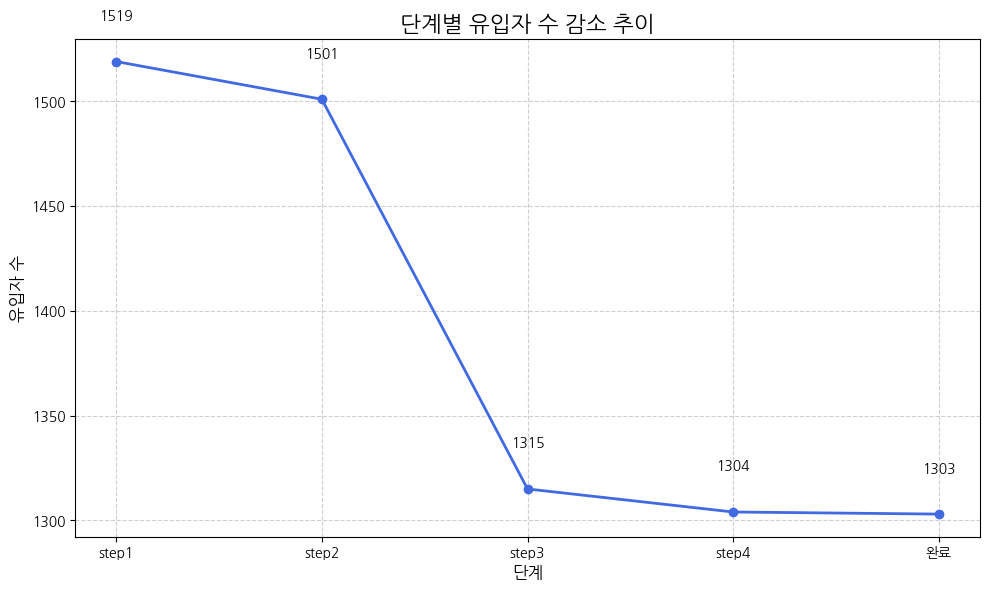

In [ ]:
# 단계 이름과 유입자 수 (너의 실제 값으로 바꿔줘)
stage_names = ["step1", "step2", "step3", "step4", "완료"]
counts = [apply_step_1_number, apply_step_2_number, apply_step_3_number, apply_step_4_number, apply_step_4_api_number]

# 선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(stage_names, counts, marker='o', linestyle='-', color='royalblue', linewidth=2)
plt.title("단계별 유입자 수 감소 추이", fontsize=16)
plt.xlabel("단계", fontsize=12)
plt.ylabel("유입자 수", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# 각 점에 유입자 수 표시
for i, count in enumerate(counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# 합격자

In [ ]:
log_2023_df[log_2023_df['URL'].str.contains('status',case=False,na=False)]['URL'].value_counts()

,count
URL,
@user_id/applications?status=received,12299
@user_id/applications?status=application-reviewing,8665
@user_id/applications?status=application-passed,4445
@user_id/applications?status=failed,3874
@user_id/applications?status=temp,3459
...,...
api/search/template?keywords=출판 마케팅&location=서울특별시&q=&status=2,1
api/search/template?keywords=프로덕트 디자이너&location=서울특별시&location=성남시 분당구&location=서울특별시 강남구&status=3&status=2,1
api/search/template?job=3&location=서울특별시&q=&status=2,1


In [ ]:
log_2023_df[log_2023_df['URL'].str.contains('passed',case=False,na=False)]['URL'].value_counts()

,count
URL,
@user_id/applications?status=application-passed,4445
@user_id/applications?status=passed,1072
@user_id/applications?status=interview-passed,977
companies/company_id?utm_source=notification&utm_medium=email&utm_campaign=application_passed&utm_content=view_company,54
jobs/id/id_title?utm_source=notification&utm_medium=email&utm_campaign=application_passed&utm_content=view_job,53
@user_id?utm_source=notification&utm_medium=email&utm_campaign=job_passed_and_not_added_member&utm_content=user_profile,2
@user_id/applications?status=application-passed&page=2,2
@user_id/applications?status=application-passed&page=1,1
@user_id/applications?status=application-passed&page=3,1


## 최종 합격한 사람 (@user_id/applications?status=passed)

In [ ]:
log_passed_members = log_2023_df[log_2023_df['URL'] == "@user_id/applications?status=passed"]["user_uuid"].unique()

finally_passed_df = apply_step_4_api_df[apply_step_4_api_df['user_uuid'].isin(log_passed_members)]
finally_passed_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
5629941,5629941,c17d8128-1de6-4a9f-960e-57f7701aa30d,api/jobs/id/apply/step4,2023-01-08 13:29:47.010941,2023-01-08,200,POST,api/jobs/id/apply/step4
5629836,5629836,c17d8128-1de6-4a9f-960e-57f7701aa30d,api/jobs/id/apply/step4,2023-01-08 13:33:23.325313,2023-01-08,200,POST,api/jobs/id/apply/step4
5630078,5630078,c17d8128-1de6-4a9f-960e-57f7701aa30d,api/jobs/id/apply/step4,2023-01-08 13:37:14.605528,2023-01-08,200,POST,api/jobs/id/apply/step4
5631390,5631390,c17d8128-1de6-4a9f-960e-57f7701aa30d,api/jobs/id/apply/step4,2023-01-09 11:19:15.181983,2023-01-09,200,POST,api/jobs/id/apply/step4
5631089,5631089,c17d8128-1de6-4a9f-960e-57f7701aa30d,api/jobs/id/apply/step4,2023-01-10 18:01:29.599173,2023-01-11,200,POST,api/jobs/id/apply/step4
...,...,...,...,...,...,...,...,...
702191,702191,fadd7420-5c59-43ec-b1e4-932c34d0a450,api/jobs/id/apply/step4,2023-12-24 09:04:30.416161,2023-12-24,200,POST,api/jobs/id/apply/step4
702905,702905,fadd7420-5c59-43ec-b1e4-932c34d0a450,api/jobs/id/apply/step4,2023-12-26 05:33:55.300668,2023-12-26,200,POST,api/jobs/id/apply/step4
703011,703011,fadd7420-5c59-43ec-b1e4-932c34d0a450,api/jobs/id/apply/step4,2023-12-27 17:01:49.982284,2023-12-28,200,POST,api/jobs/id/apply/step4
322154,322154,cbb20503-3862-42c9-ac13-e3975dcdfda5,api/jobs/id/apply/step4,2023-12-29 07:56:51.010307,2023-12-29,200,POST,api/jobs/id/apply/step4


In [ ]:
apply_step_4_api_df["user_uuid"].nunique()

1303

In [ ]:
finally_passed_df["user_uuid"].nunique()

98

In [ ]:
finally_passed_members = finally_passed_df["user_uuid"].unique()

## 최종 합격자 제외 인터뷰 합격자

In [ ]:
not_finally_passed_df = apply_step_4_api_df[~apply_step_4_api_df["user_uuid"].isin(finally_passed_members)]

not_finally_passed_members = not_finally_passed_df["user_uuid"].unique()

log_interview_passed_members = log_2023_df[log_2023_df['URL'] == "@user_id/applications?status=interview-passed"]["user_uuid"].unique()

interview_passed_df = not_finally_passed_df[not_finally_passed_df['user_uuid'].isin(log_interview_passed_members)]

In [ ]:
len(not_finally_passed_members)

1205

In [ ]:
interview_passed_df["user_uuid"].nunique()

40

In [ ]:
interview_passed_members = interview_passed_df["user_uuid"].unique()

## 인터뷰 합격자 제외 서류 합격자

In [ ]:
not_interview_passed_df = not_finally_passed_df[~not_finally_passed_df["user_uuid"].isin(interview_passed_members)]

not_interview_passed_members = not_interview_passed_df["user_uuid"].unique()

log_application_passed_members = log_2023_df[log_2023_df['URL'] == "@user_id/applications?status=application-passed"]["user_uuid"].unique()

application_passed_df = not_interview_passed_df[not_interview_passed_df['user_uuid'].isin(log_application_passed_members)]

In [ ]:
not_interview_passed_df["user_uuid"].nunique()

1165

In [ ]:
application_passed_df["user_uuid"].nunique()

111

In [ ]:
application_passed_members = application_passed_df["user_uuid"].unique()

## 서류 합격까지 모두 제외

In [ ]:
# numpy의 set 차집합 기능 사용
losers = np.setdiff1d(
    not_interview_passed_df["user_uuid"].unique(),
    application_passed_df["user_uuid"].unique()
)

In [ ]:
len(losers)

1054

## 서류 합격 (total_application_passed_df) vs 불합격 (total_losers_df)

In [ ]:
total_application_passed_members = apply_step_4_api_df[~apply_step_4_api_df["user_uuid"].isin(losers)]["user_uuid"].unique()
total_application_passed_df = log_2023_df[log_2023_df["user_uuid"].isin(total_application_passed_members)]
total_losers_df = log_2023_df[log_2023_df["user_uuid"].isin(losers)]

In [ ]:
apply_step_4_api_df["user_uuid"].nunique()

1303

In [ ]:
total_application_passed_df["user_uuid"].nunique()

249

In [ ]:
total_losers_df["user_uuid"].nunique()

1054

## 페이지별 체류시간

In [ ]:
step_keywords = ['step1', 'step2', 'step3', 'step4']

step_mask = log_2023_df["cleaned_url"].apply(
    lambda url: isinstance(url, str) and any(kw in url for kw in step_keywords)
)
step_logs = log_2023_df[step_mask].copy()

# 2. user + timestamp 기준 정렬 후 체류 시간 계산
step_logs = step_logs.sort_values(by=["user_uuid", "timestamp"])
step_logs["next_timestamp"] = step_logs.groupby("user_uuid")["timestamp"].shift(-1)
step_logs["stay_duration"] = (step_logs["next_timestamp"] - step_logs["timestamp"]).dt.total_seconds()

# 3. step 추출: numpy array + vectorized 방식
step_map = {kw: kw for kw in step_keywords}
step_logs["step"] = np.select(
    [step_logs["cleaned_url"].str.contains(kw, na=False) for kw in step_keywords],
    step_keywords,
    default="기타"
)

# 4. 상태 분류: set을 활용한 빠른 조회
passed_users = set(total_application_passed_df["user_uuid"])
failed_users = set(total_losers_df["user_uuid"])

def classify_status(user_uuid):
    if user_uuid in passed_users:
        return "합격자"
    elif user_uuid in failed_users:
        return "불합격자"
    else:
        return "기타"

step_logs["status"] = step_logs["user_uuid"].map(classify_status)

# 5. 체류시간 2초 이하 제거
step_logs = step_logs[step_logs["stay_duration"] > 2]

# 6. 최종 평균 체류시간 계산
step_time_stats = step_logs[step_logs["status"].isin(["합격자", "불합격자"])] \
    .groupby(["status", "step"])["stay_duration"].mean().reset_index()

# 초 → 분 변환
step_time_stats["stay_duration_minutes"] = (step_time_stats["stay_duration"] / 60).round(2)

# 결과 보기 좋게 정리
step_time_stats = step_time_stats[["status", "step", "stay_duration_minutes"]]

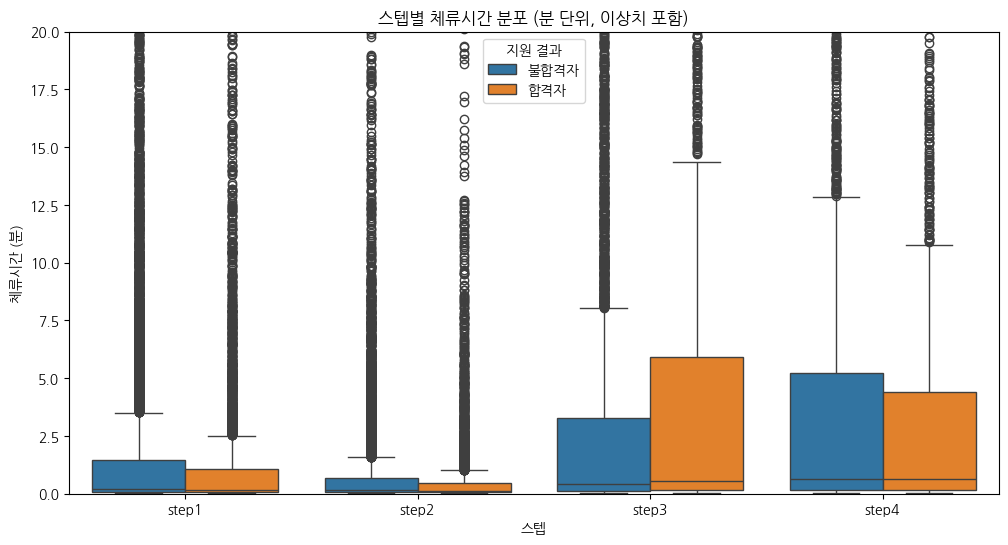

In [ ]:
# 체류시간을 분 단위로 변환
step_logs["stay_minutes"] = (step_logs["stay_duration"] / 60).round(2)

# 합격자/불합격자 중에서만 확인
filtered = step_logs[step_logs["status"].isin(["합격자", "불합격자"])]

# Boxplot으로 이상치 확인
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered, x="step", y="stay_minutes", hue="status")
plt.ylim(0, 20)
plt.title("스텝별 체류시간 분포 (분 단위, 이상치 포함)")
plt.ylabel("체류시간 (분)")
plt.xlabel("스텝")
plt.legend(title="지원 결과")
plt.show()

In [ ]:
# 체류시간 분 단위로 변환
step_logs["stay_minutes"] = step_logs["stay_duration"] / 60
filtered = step_logs[step_logs["status"].isin(["합격자", "불합격자"])]

# 이상치 제거 함수 정의
def remove_iqr_outliers(df):
    result = []

    for (status, step), group in df.groupby(["status", "step"]):
        q1 = group["stay_minutes"].quantile(0.25)
        q3 = group["stay_minutes"].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr

        cleaned_group = group[(group["stay_minutes"] <= upper_bound) & (group["stay_minutes"] >= lower_bound)].copy()
        result.append(cleaned_group)

    return pd.concat(result)

# IQR 기반 이상치 제거
filtered_clean = remove_iqr_outliers(filtered)

# 이상치 제거 후 평균 체류시간 재계산
mean_stats_iqr = filtered_clean.groupby(["status", "step"])["stay_minutes"].mean().reset_index()
mean_stats_iqr["stay_minutes"] = mean_stats_iqr["stay_minutes"].round(2)

mean_stats_iqr

,status,step,stay_minutes
0,불합격자,step1,0.42
1,불합격자,step2,0.28
2,불합격자,step3,0.85
3,불합격자,step4,1.15
4,합격자,step1,0.32
5,합격자,step2,0.19
6,합격자,step3,1.33
7,합격자,step4,1.07


## 합격자 vs 불합격자 리텐션 분석

### 불합격자 월별 코호트 리텐션 차트 그리기

In [ ]:
loser_logs = log_2023_df[log_2023_df["user_uuid"].isin(total_losers_df["user_uuid"])].copy()

loser_logs["timestamp"] = pd.to_datetime(loser_logs["timestamp"])
loser_logs["activity_month"] = loser_logs["timestamp"].dt.to_period("M").dt.to_timestamp()


loser_logs["cohort_month"] = loser_logs.groupby("user_uuid")["timestamp"].transform("min").dt.to_period("M").dt.to_timestamp()


loser_logs["month_index"] = (
    (loser_logs["activity_month"].dt.to_period("M") - loser_logs["cohort_month"].dt.to_period("M"))
).apply(lambda x: x.n)

#  코호트별 월간 활동 유저 수 계산
cohort_counts = loser_logs.groupby(["cohort_month", "month_index"])["user_uuid"].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index="cohort_month", columns="month_index", values="user_uuid")

# 리텐션율 계산
cohort_sizes = cohort_pivot[0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0).round(3)

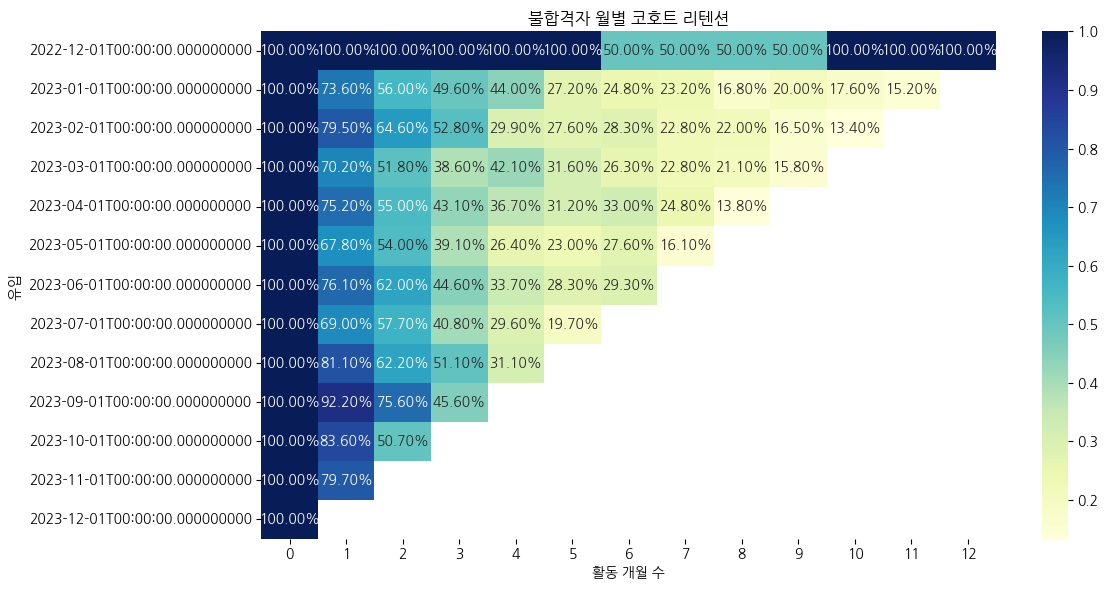

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title("불합격자 월별 코호트 리텐션")
plt.xlabel("활동 개월 수")
plt.ylabel("유입 ")
plt.tight_layout()
plt.show()

### 합격자 월별 코호트 리텐션 차트 그리기

In [ ]:
total_application_passed_df["timestamp"] = pd.to_datetime(total_application_passed_df["timestamp"])
total_application_passed_df["activity_month"] = total_application_passed_df["timestamp"].dt.to_period("M").dt.to_timestamp()


total_application_passed_df["cohort_month"] = total_application_passed_df.groupby("user_uuid")["timestamp"].transform("min").dt.to_period("M").dt.to_timestamp()


total_application_passed_df["month_index"] = (
    (total_application_passed_df["activity_month"].dt.to_period("M") - total_application_passed_df["cohort_month"].dt.to_period("M"))
).apply(lambda x: x.n)

#  코호트별 월간 활동 유저 수 계산
cohort_counts = total_application_passed_df.groupby(["cohort_month", "month_index"])["user_uuid"].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index="cohort_month", columns="month_index", values="user_uuid")

# 리텐션율 계산
cohort_sizes = cohort_pivot[0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0).round(3)

<ipython-input-48-ed5daa572d14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_application_passed_df["timestamp"] = pd.to_datetime(total_application_passed_df["timestamp"])
<ipython-input-48-ed5daa572d14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_application_passed_df["activity_month"] = total_application_passed_df["timestamp"].dt.to_period("M").dt.to_timestamp()
<ipython-input-48-ed5daa572d14>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

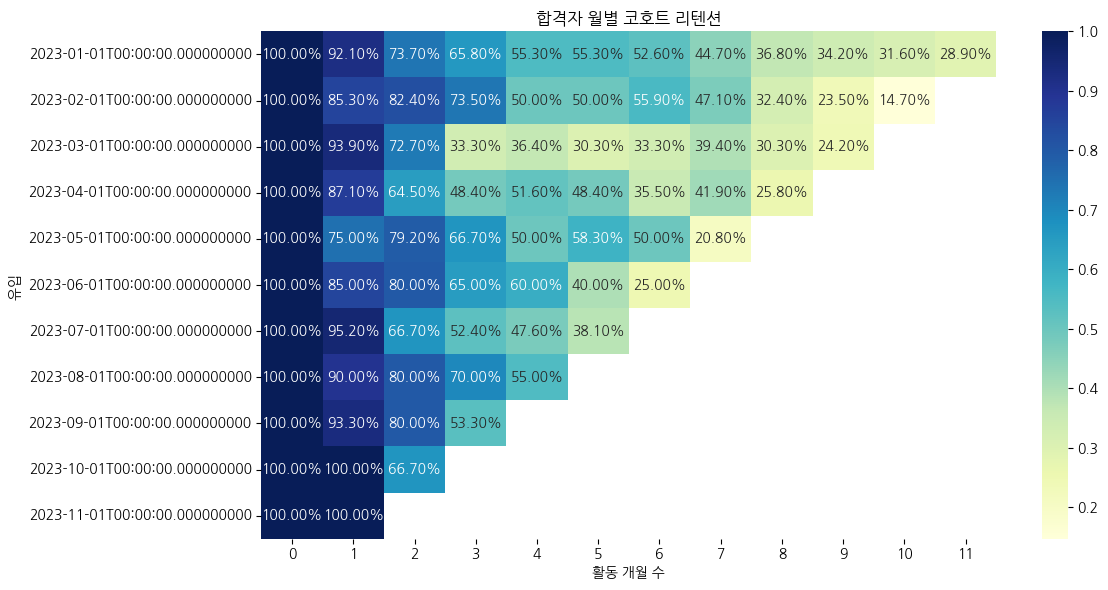

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title("합격자 월별 코호트 리텐션")
plt.xlabel("활동 개월 수")
plt.ylabel("유입 ")
plt.tight_layout()
plt.show()

### 불합격자 수 405명(random_losers_df)으로 다시 해보기

In [ ]:
loser_members = total_losers_df["user_uuid"].unique()

random_loser_members = np.random.choice(loser_members, size=249, replace=False)

random_losers_df = total_losers_df[total_losers_df["user_uuid"].isin(random_loser_members)]

In [ ]:
loser_logs = log_2023_df[log_2023_df["user_uuid"].isin(random_losers_df["user_uuid"])].copy()

loser_logs["timestamp"] = pd.to_datetime(loser_logs["timestamp"])
loser_logs["activity_month"] = loser_logs["timestamp"].dt.to_period("M").dt.to_timestamp()


loser_logs["cohort_month"] = loser_logs.groupby("user_uuid")["timestamp"].transform("min").dt.to_period("M").dt.to_timestamp()


loser_logs["month_index"] = (
    (loser_logs["activity_month"].dt.to_period("M") - loser_logs["cohort_month"].dt.to_period("M"))
).apply(lambda x: x.n)

#  코호트별 월간 활동 유저 수 계산
cohort_counts = loser_logs.groupby(["cohort_month", "month_index"])["user_uuid"].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index="cohort_month", columns="month_index", values="user_uuid")

# 리텐션율 계산
cohort_sizes = cohort_pivot[0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0).round(3)

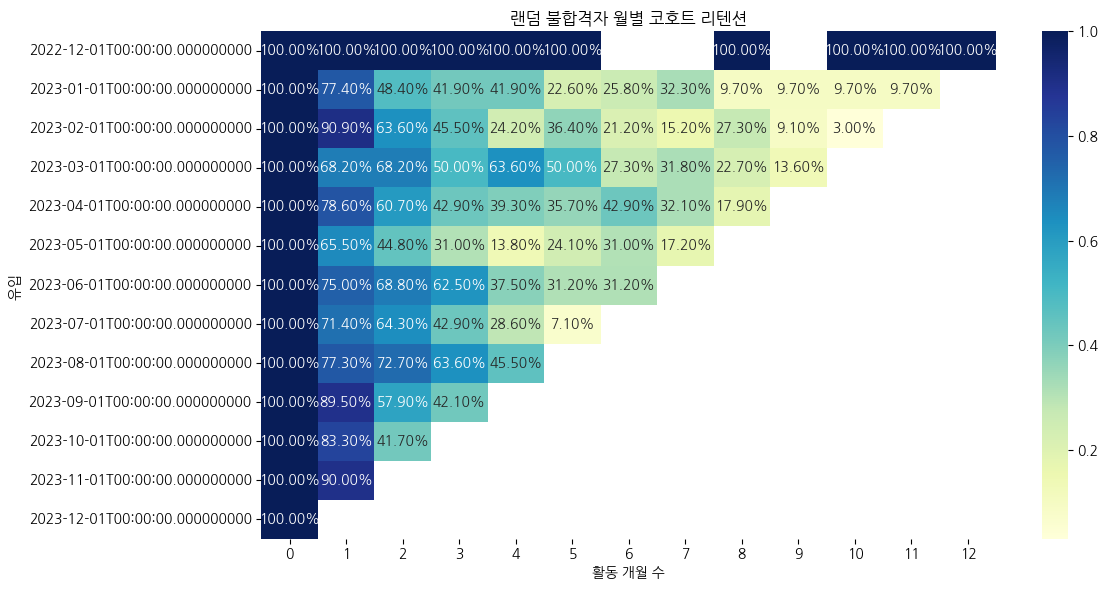

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title("랜덤 불합격자 월별 코호트 리텐션")
plt.xlabel("활동 개월 수")
plt.ylabel("유입 ")
plt.tight_layout()
plt.show()

## 합격자와 불합격자 중 누가 더 지원을 많이 했는가?

In [ ]:
# Step 1: 특정 cleaned_url 값 필터링
losers_apply_complete_df = total_losers_df[total_losers_df['cleaned_url'] == 'api/jobs/id/apply/step4']

# Step 2: user_uuid별로 groupby 후 count
losers_apply_complete_counts = losers_apply_complete_df.groupby('user_uuid').size()

# Step 3: 평균 계산
losers_apply_complete_average_count = losers_apply_complete_counts.mean()

print(f"불합격자의 평균 지원 완료 횟수: {losers_apply_complete_average_count}")

불합격자의 평균 지원 완료 횟수: 6.307400379506642


In [ ]:
# Step 1: 특정 cleaned_url 값 필터링
passed_apply_complete_df = total_application_passed_df[total_application_passed_df['cleaned_url'] == 'api/jobs/id/apply/step4']

# Step 2: user_uuid별로 groupby 후 count
passed_apply_complete_counts = passed_apply_complete_df.groupby('user_uuid').size()

# Step 3: 평균 계산
passed_apply_complete_average_count = passed_apply_complete_counts.mean()

print(f"합격자의 평균 지원 완료 횟수: {passed_apply_complete_average_count}")

합격자의 평균 지원 완료 횟수: 12.02008032128514


## 구GPT의 합불 행동 패턴 분석

In [ ]:
passed_users = set(total_application_passed_df['user_uuid'])
failed_users = set(total_losers_df['user_uuid'])


log_2023_df['status'] = log_2023_df['user_uuid'].apply(
    lambda x: '합격자' if x in passed_users else ('불합격자' if x in failed_users else '기타')
)

# 합격자와 불합격자의 행동 패턴 비교, URL 기준 상위 20개 행동 비교
log_counts = log_2023_df[log_2023_df['status'].isin(['합격자', '불합격자'])] \
    .groupby(['status', 'cleaned_url'])['user_uuid'].count().reset_index()
log_counts.columns = ['status', 'cleaned_url', 'count']

# 상위 20개 행동
top_passed = log_counts[log_counts['status'] == '합격자'].sort_values(by='count', ascending=False).head(20)
top_failed = log_counts[log_counts['status'] == '불합격자'].sort_values(by='count', ascending=False).head(20)

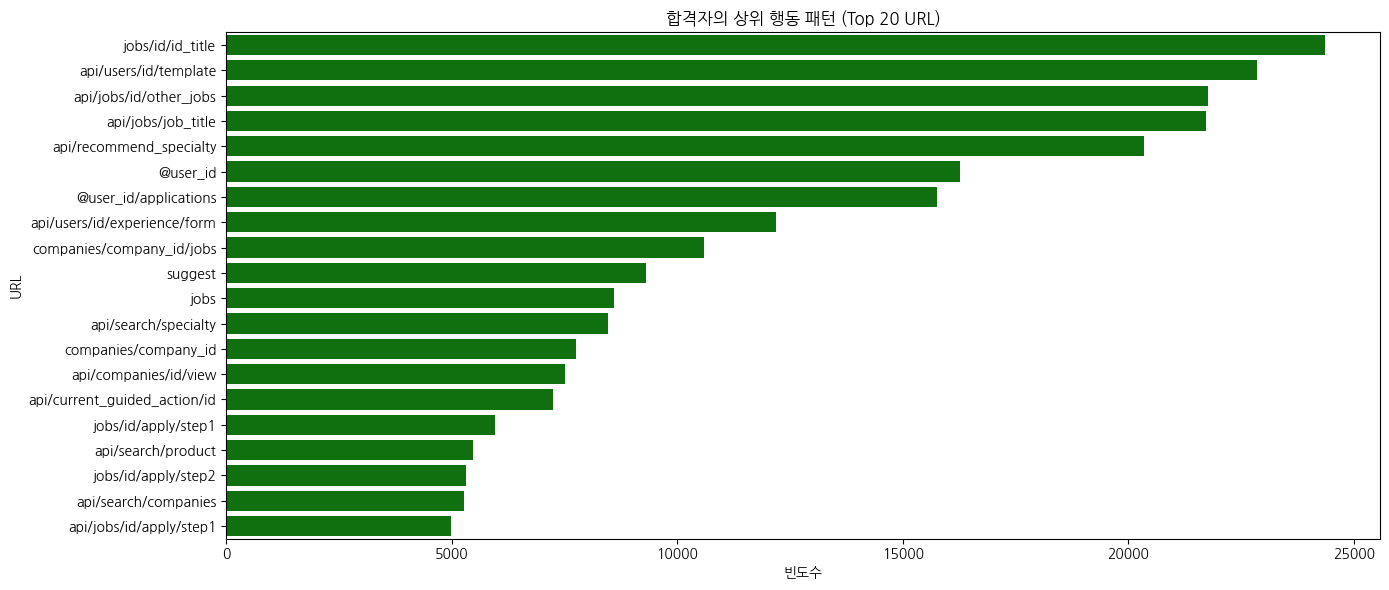

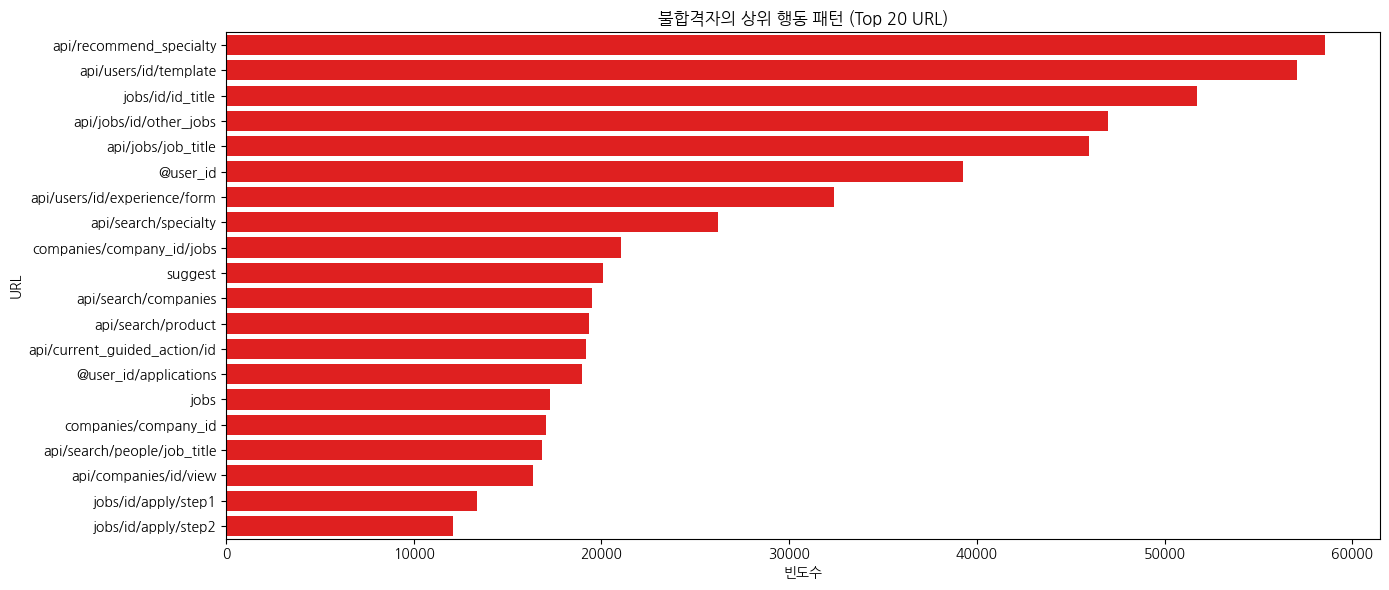

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(data=top_passed, x='count', y='cleaned_url', color='green')
plt.title("합격자의 상위 행동 패턴 (Top 20 URL)")
plt.xlabel("빈도수")
plt.ylabel("URL")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(data=top_failed, x='count', y='cleaned_url', color='red')
plt.title("불합격자의 상위 행동 패턴 (Top 20 URL)")
plt.xlabel("빈도수")
plt.ylabel("URL")
plt.tight_layout()
plt.show()

## step3 후 로그 확인 (step3 경로에 도달한 후 어떤 행동을 하는가)

In [ ]:
# 유저별로 timestamp 순 정렬
log_2023_df = log_2023_df.sort_values(by=['user_uuid', 'timestamp'])

### step3 이후 5개

In [ ]:
# 결과 저장할 리스트
results = []

# 유저별로 그룹핑
for user, group in log_2023_df.groupby('user_uuid'):
    group = group.reset_index(drop=True)

    # 'jobs/id/apply/step3'이 처음 등장하는 인덱스 찾기
    match_indices = group.index[group['cleaned_url'] == 'jobs/id/apply/step3'].tolist()

    for idx in match_indices:
        # 이후 10개의 로그 추출 (idx 포함해서 총 10개)
        subset = group.iloc[idx:idx+5]
        results.append(subset)

# 결과 합치기
after_step3_df = pd.concat(results, ignore_index=True)

# 결과 출력 (또는 저장 등)
after_step3_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,status
0,4123947,000b55ad-5c86-438b-a5b0-9ea3a2917789,jobs/id/apply/step3,2023-07-07 13:29:25.033016,2023-07-07,200,GET,jobs/id/apply/step3,불합격자
1,4123763,000b55ad-5c86-438b-a5b0-9ea3a2917789,jobs?keywords=투게더아트,2023-07-08 12:48:18.345723,2023-07-08,200,GET,jobs,불합격자
2,4123761,000b55ad-5c86-438b-a5b0-9ea3a2917789,api/jobs/job_title?keywords=투게더아트,2023-07-08 12:48:20.239631,2023-07-08,200,GET,api/jobs/job_title,불합격자
3,4123762,000b55ad-5c86-438b-a5b0-9ea3a2917789,@user_id/applications,2023-07-08 12:48:22.209079,2023-07-08,200,GET,@user_id/applications,불합격자
4,4123751,000b55ad-5c86-438b-a5b0-9ea3a2917789,jobs/id/apply/step1,2023-07-08 18:24:43.779876,2023-07-09,200,GET,jobs/id/apply/step1,불합격자
...,...,...,...,...,...,...,...,...,...
262754,1776626,ffff25ca-c1d7-4fc2-891b-b0df92f95092,jobs/id/apply/step3,2023-11-29 14:23:33.639992,2023-11-29,200,GET,jobs/id/apply/step3,기타
262755,1776621,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/jobs/id/apply/step3,2023-11-29 14:23:41.449743,2023-11-29,200,POST,api/jobs/id/apply/step3,기타
262756,1776716,ffff25ca-c1d7-4fc2-891b-b0df92f95092,jobs/id/apply/step4,2023-11-29 14:23:42.002444,2023-11-29,200,GET,jobs/id/apply/step4,기타
262757,1776649,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/jobs/id/apply/step4,2023-11-29 14:23:45.753890,2023-11-29,200,POST,api/jobs/id/apply/step4,기타


In [ ]:
# step3 이후의 행동만 추출 (step3 자체는 제외)
after_only_df = after_step3_df[after_step3_df['cleaned_url'] != 'jobs/id/apply/step3']

# 행동별 전체 카운트 집계
after_step3_top10_actions = (
    after_only_df['cleaned_url']
    .value_counts()
    .reset_index()
)

# 컬럼 이름 정리
after_step3_top10_actions.columns = ['cleaned_url', 'count']

# 결과 출력
after_step3_top10_actions

,cleaned_url,count
0,api/jobs/id/apply/step3,36223
1,jobs/id/apply/step4,26081
2,api/jobs/id/apply/step4,19587
3,jobs/id/id_title,14778
4,jobs/id/apply/complete,9313
...,...,...
146,api/companies/id/reference/id,1
147,api/search/users,1
148,email_security,1
149,api/users/id/residence,1


### step3 바로 직후

In [ ]:
# 결과 저장할 리스트
results = []

# 유저별로 그룹핑
for user, group in log_2023_df.groupby('user_uuid'):
    group = group.reset_index(drop=True)

    # 'jobs/id/apply/step3'이 처음 등장하는 인덱스 찾기
    match_indices = group.index[group['cleaned_url'] == 'jobs/id/apply/step3'].tolist()

    for idx in match_indices:
        # 이후 10개의 로그 추출 (idx 포함해서 총 10개)
        subset = group.iloc[idx:idx+2]
        results.append(subset)

# 결과 합치기
next_step3_df = pd.concat(results, ignore_index=True)

# 결과 출력 (또는 저장 등)
next_step3_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,status
0,4123947,000b55ad-5c86-438b-a5b0-9ea3a2917789,jobs/id/apply/step3,2023-07-07 13:29:25.033016,2023-07-07,200,GET,jobs/id/apply/step3,불합격자
1,4123763,000b55ad-5c86-438b-a5b0-9ea3a2917789,jobs?keywords=투게더아트,2023-07-08 12:48:18.345723,2023-07-08,200,GET,jobs,불합격자
2,4123741,000b55ad-5c86-438b-a5b0-9ea3a2917789,jobs/id/apply/step3,2023-07-09 12:53:12.330126,2023-07-09,200,GET,jobs/id/apply/step3,불합격자
3,4123746,000b55ad-5c86-438b-a5b0-9ea3a2917789,@user_id,2023-07-09 12:53:40.986976,2023-07-09,200,GET,@user_id,불합격자
4,4124159,000b55ad-5c86-438b-a5b0-9ea3a2917789,jobs/id/apply/step3,2023-07-12 07:09:06.828881,2023-07-12,200,GET,jobs/id/apply/step3,불합격자
...,...,...,...,...,...,...,...,...,...
105206,1776599,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/jobs/id/apply/step3,2023-11-29 14:16:59.666569,2023-11-29,200,POST,api/jobs/id/apply/step3,기타
105207,1776609,ffff25ca-c1d7-4fc2-891b-b0df92f95092,jobs/id/apply/step3,2023-11-29 14:19:40.618461,2023-11-29,200,GET,jobs/id/apply/step3,기타
105208,1776657,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/jobs/id/apply/step3,2023-11-29 14:19:53.102233,2023-11-29,200,POST,api/jobs/id/apply/step3,기타
105209,1776626,ffff25ca-c1d7-4fc2-891b-b0df92f95092,jobs/id/apply/step3,2023-11-29 14:23:33.639992,2023-11-29,200,GET,jobs/id/apply/step3,기타


In [ ]:
# step3 이후의 행동만 추출 (step3 자체는 제외)
next_only_df = next_step3_df[next_step3_df['cleaned_url'] != 'jobs/id/apply/step3']

# 행동별 전체 카운트 집계
next_step3_top10_actions = (
    next_only_df['cleaned_url']
    .value_counts()
    .reset_index()
)

# 컬럼 이름 정리
next_step3_top10_actions.columns = ['cleaned_url', 'count']

# 결과 출력
next_step3_top10_actions

,cleaned_url,count
0,api/jobs/id/apply/step3,27237
1,jobs/id/apply/step2,4932
2,jobs/id/id_title,3948
3,jobs/id/apply/step1,1876
4,companies/company_id/jobs,1737
...,...,...
97,api/post/id/template/viewers,1
98,api/users/id/overview,1
99,api/users/id/project/id,1
100,email_security,1


# 2025-04-24 할 일

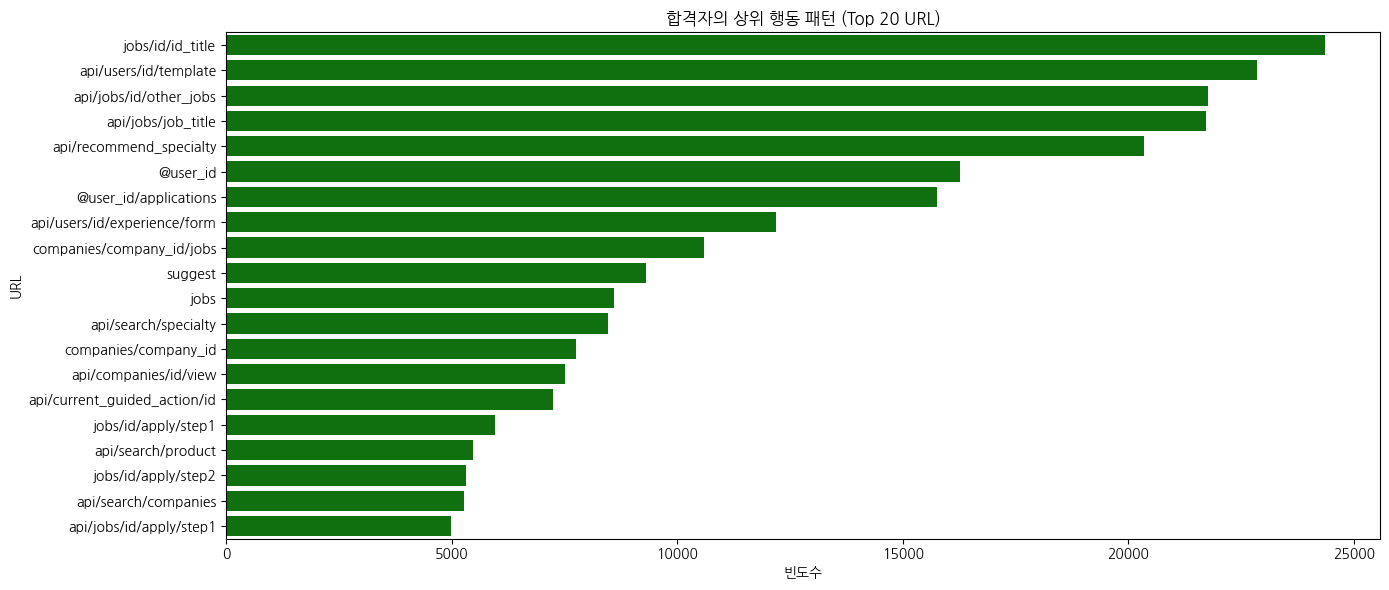

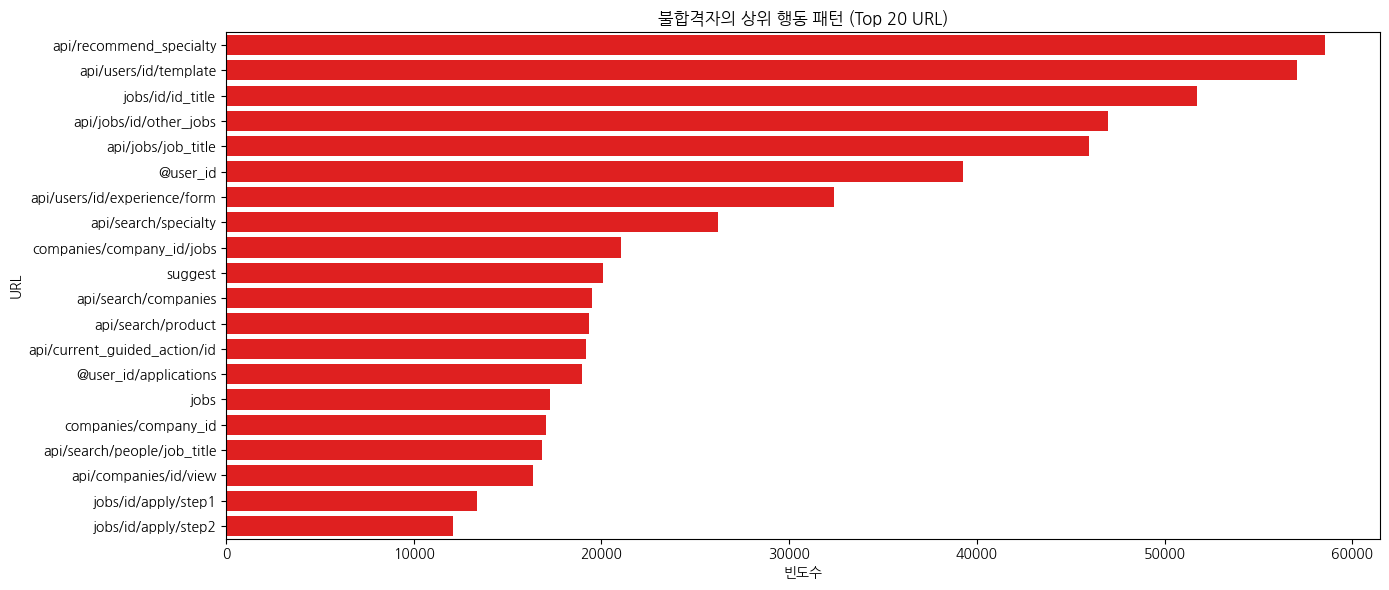

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(data=top_passed, x='count', y='cleaned_url', color='green')
plt.title("합격자의 상위 행동 패턴 (Top 20 URL)")
plt.xlabel("빈도수")
plt.ylabel("URL")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(data=top_failed, x='count', y='cleaned_url', color='red')
plt.title("불합격자의 상위 행동 패턴 (Top 20 URL)")
plt.xlabel("빈도수")
plt.ylabel("URL")
plt.tight_layout()
plt.show()

In [ ]:
top_passed

,status,cleaned_url,count
389,합격자,jobs/id/id_title,24364
354,합격자,api/users/id/template,22847
260,합격자,api/jobs/id/other_jobs,21768
263,합격자,api/jobs/job_title,21734
278,합격자,api/recommend_specialty,20353
213,합격자,@user_id,16280
215,합격자,@user_id/applications,15771
322,합격자,api/users/id/experience/form,12184
368,합격자,companies/company_id/jobs,10587
408,합격자,suggest,9317


In [ ]:
top_failed

,status,cleaned_url,count
75,불합격자,api/recommend_specialty,58547
151,불합격자,api/users/id/template,57057
188,불합격자,jobs/id/id_title,51738
57,불합격자,api/jobs/id/other_jobs,47000
60,불합격자,api/jobs/job_title,45993
1,불합격자,@user_id,39281
119,불합격자,api/users/id/experience/form,32398
90,불합격자,api/search/specialty,26203
165,불합격자,companies/company_id/jobs,21046
208,불합격자,suggest,20066
